In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from datetime import date

In [17]:
from data_preprocessing import *

settings = {
    'directory': '/data/rainbolt/sh4b/mixed_selection/background/',
    'n_seeds': 25,
    'trigger_tag': '',
    'model_tag': '',
    'btag': 77,
    'xbbtag': 70,
    # 'sig_region': '2dfit','None'
    'sig_region': '2dfit',
    'trig': 'LR_2b1j',
    'info': 'Rebinning_studies',
}

truth_X, truth_S, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw = prepare_hist_all(settings)

Getting signals from /data/rainbolt/sh4b/mixed_selection/signal/
for 2018 , mc20e
Getting signals from /data/rainbolt/sh4b/mixed_selection/signal/
for 2017 , mc20d
Getting signals from /data/rainbolt/sh4b/mixed_selection/signal/
for 2016 , mc20a
Getting background
Getting backgrounds for year = 2016
Getting backgrounds for year = 2017
Getting backgrounds for year = 2018


In [13]:
import numpy as np
import matplotlib.pyplot as plt

class HistogramRebinning:
    def __init__(self, sig_hist, bkg_hist, z_s=10, z_b=5):
        self.sig_counts, self.sig_edges = sig_hist
        self.bkg_counts, self.bkg_edges = bkg_hist
        self.z_s = z_s
        self.z_b = z_b

        # Ensure histograms have the same bin edges
        assert np.allclose(self.sig_edges, self.bkg_edges), "Histogram edges must match."

    def rebin_histograms(self):
        sig_counts = self.sig_counts.copy()
        bkg_counts = self.bkg_counts.copy()
        bin_edges = list(self.sig_edges)

        N_s = np.sum(sig_counts)
        N_b = np.sum(bkg_counts)

        new_edges = [bin_edges[-1]]  # Start from the rightmost edge
        sig_rebinned = []
        bkg_rebinned = []

        n_s = 0
        n_b = 0

        # Iteratively merge bins
        for i in reversed(range(len(sig_counts))):
            n_s += sig_counts[i]
            n_b += bkg_counts[i]
            llrs = n_s/(np.sqrt(n_b))
            llrb = n_b/(np.sqrt(n_s))
            LLRs = N_s/(np.sqrt(N_b))
            LLRb = N_b/(np.sqrt(N_s))
            
            
            # Calculate the Z function
            Z = self.z_s * (n_s / N_s) + self.z_b * (n_b / N_b)
            Z_E = np.sqrt((self.z_s*llrs)/LLRs) + np.sqrt((self.z_b*llrb)/LLRb)

            sigma = n_s/(np.sqrt(n_s+n_b))
            stat_unc_s = 1/(np.sqrt(n_s))
            stat_unc_b = 1/(np.sqrt(n_b))
            
            
            # if Z > 1:
            # and stat_unc_s < 0.9
            if stat_unc_b < 0.2:
                # Create a new bin
                print(f"Z = {Z}, stat_unc_b = {stat_unc_b}, stat_unc_s = {stat_unc_s}")
                # , n_s = {n_s}, n_b = {n_b}, sigma = {sigma}
                new_edges.append(bin_edges[i])
                sig_rebinned.append(n_s)
                bkg_rebinned.append(n_b)
                n_s = 0
                n_b = 0

        # Handle any remaining events
        if n_s > 0 or n_b > 0:
            new_edges.append(bin_edges[0])
            sig_rebinned.append(n_s)
            bkg_rebinned.append(n_b)

        # Reverse lists to correct order
        new_edges.reverse()
        sig_rebinned.reverse()
        bkg_rebinned.reverse()

        return new_edges, sig_rebinned, bkg_rebinned

    def rebin_fixed_bins(self, old_counts, old_edges, new_edges):
        """Rebins histogram counts from old_edges into new_edges."""
        new_counts = np.histogram(old_edges[:-1], bins=new_edges, weights=old_counts)[0]
        return new_counts
    
    def plot_histograms(self, bin_edges, sig_counts, bkg_counts):
        fig, ax = plt.subplots(figsize=(8, 5))
        bin_widths = np.diff(bin_edges)
        # ax.bar(bin_edges[:-1], bkg_counts, width=bin_widths, align='edge', alpha=0.5, label='Background')
        # ax.bar(bin_edges[:-1], sig_counts, width=bin_widths, align='edge', alpha=0.9, label='Signal')
        
        # ax.step(bin_edges, np.append(sig_counts, sig_counts[-1]), where='post', linestyle='-', linewidth=2, label='Signal', color='blue')
        # ax.step(bin_edges, np.append(bkg_counts, bkg_counts[-1]), where='post', linestyle='-', linewidth=2, label='Background', color='red')

        ax.stairs(sig_counts, bin_edges, linestyle='-', linewidth=2, label='Signal')
        ax.stairs(bkg_counts, bin_edges, linestyle='-', linewidth=2, label='Background')

        ax.set_xlabel('Variable')
        ax.set_ylabel('Counts')
        ax.set_yscale('log')  # Set the y-axis to logarithmic scale
        ax.legend()
        ax.set_title('Rebinned Histograms')
        plt.show()


/tmp/ipykernel_2234/1098717644.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  llrs = n_s/(np.sqrt(n_b))
/tmp/ipykernel_2234/1098717644.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  LLRs = N_s/(np.sqrt(N_b))
/tmp/ipykernel_2234/1098717644.py:40: RuntimeWarning: invalid value encountered in scalar divide
  Z = self.z_s * (n_s / N_s) + self.z_b * (n_b / N_b)
/tmp/ipykernel_2234/1098717644.py:41: RuntimeWarning: invalid value encountered in scalar multiply
  Z_E = np.sqrt((self.z_s*llrs)/LLRs) + np.sqrt((self.z_b*llrb)/LLRb)
/tmp/ipykernel_2234/1098717644.py:41: RuntimeWarning: invalid value encountered in scalar divide
  Z_E = np.sqrt((self.z_s*llrs)/LLRs) + np.sqrt((self.z_b*llrb)/LLRb)
/tmp/ipykernel_2234/1098717644.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  stat_unc_b = 1/(np.sqrt(n_b))


Plotting rebinned histograms for key: 6000_3000


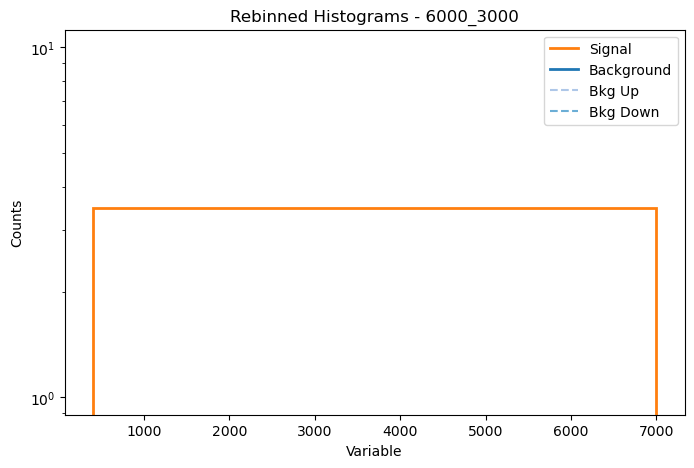

Z = 1.1428694118730136, stat_unc_b = 0.11515800284455247, stat_unc_s = 3.705596719994878
Z = 1.453419260719273, stat_unc_b = 0.10211674743902592, stat_unc_s = 1.8387498312047095
Z = 1.4190397111530983, stat_unc_b = 0.10334635278660118, stat_unc_s = 2.2882257622416664
Z = 0.8800081107568436, stat_unc_b = 0.13123482352792354, stat_unc_s = 5.280356172910233
Plotting rebinned histograms for key: 750_250


/tmp/ipykernel_2234/1098717644.py:33: RuntimeWarning: invalid value encountered in scalar divide
  llrs = n_s/(np.sqrt(n_b))
/tmp/ipykernel_2234/1098717644.py:34: RuntimeWarning: invalid value encountered in scalar divide
  llrb = n_b/(np.sqrt(n_s))
/tmp/ipykernel_2234/1098717644.py:43: RuntimeWarning: invalid value encountered in scalar divide
  sigma = n_s/(np.sqrt(n_s+n_b))
/tmp/ipykernel_2234/1098717644.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  stat_unc_s = 1/(np.sqrt(n_s))


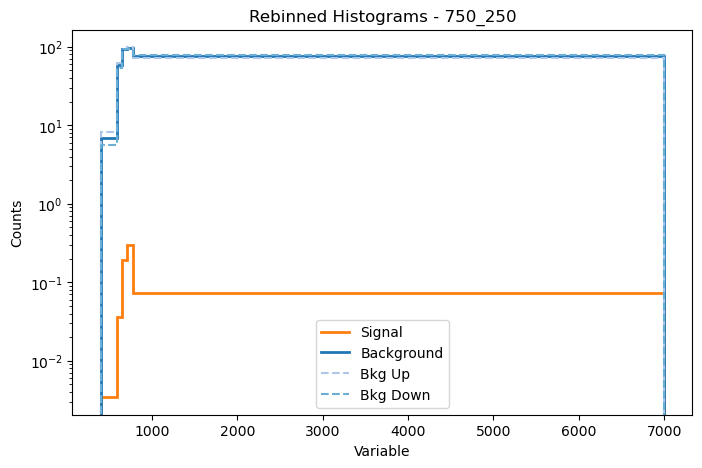

Z = 1.1383331133362335, stat_unc_b = 0.12137146882621015, stat_unc_s = 3.234369876363964
Z = 1.6053112445835362, stat_unc_b = 0.10220488845068858, stat_unc_s = 1.6586232478126381
Z = 1.5289312575285496, stat_unc_b = 0.10472667439812366, stat_unc_s = 2.2521894904856126
Z = 0.7274243845516801, stat_unc_b = 0.15182992056254557, stat_unc_s = 5.823628213879506
Plotting rebinned histograms for key: 750_200


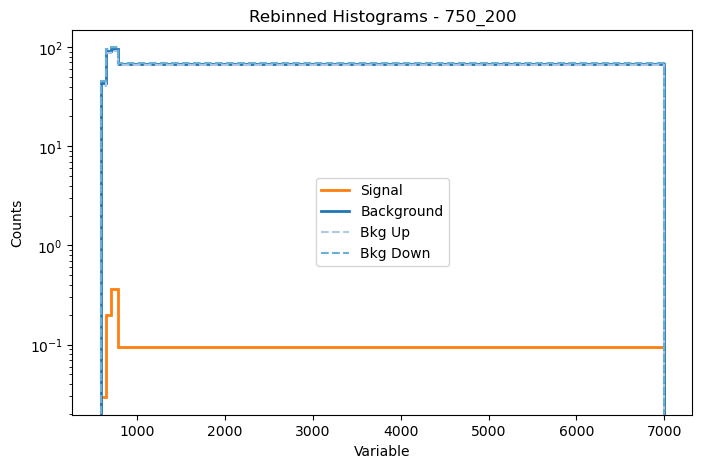

Plotting rebinned histograms for key: 4000_200


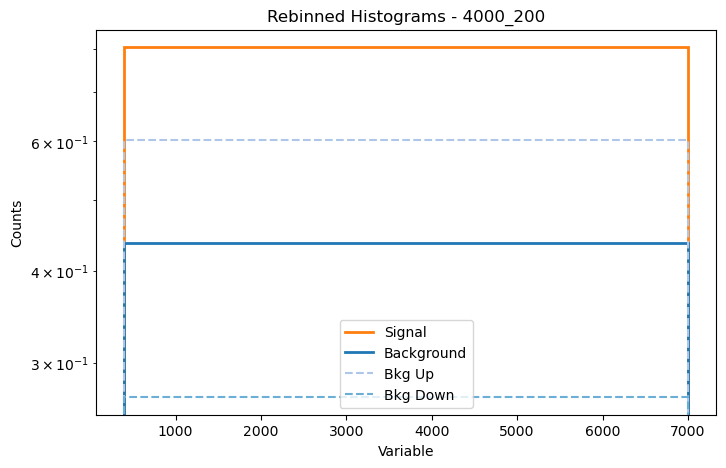

Plotting rebinned histograms for key: 2500_1000


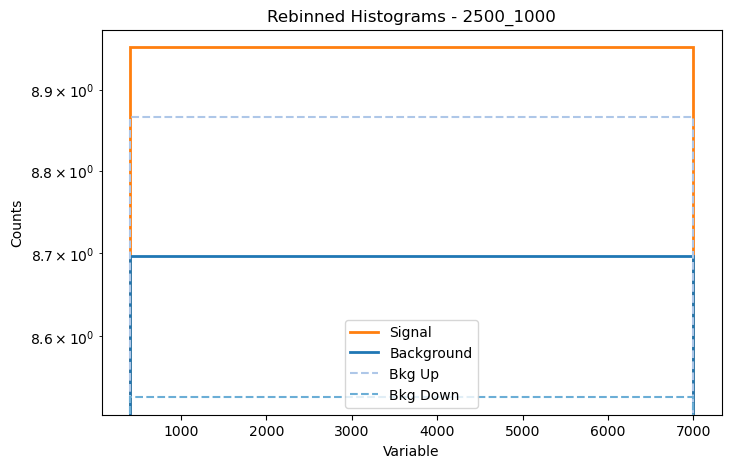

Plotting rebinned histograms for key: 3000_1500


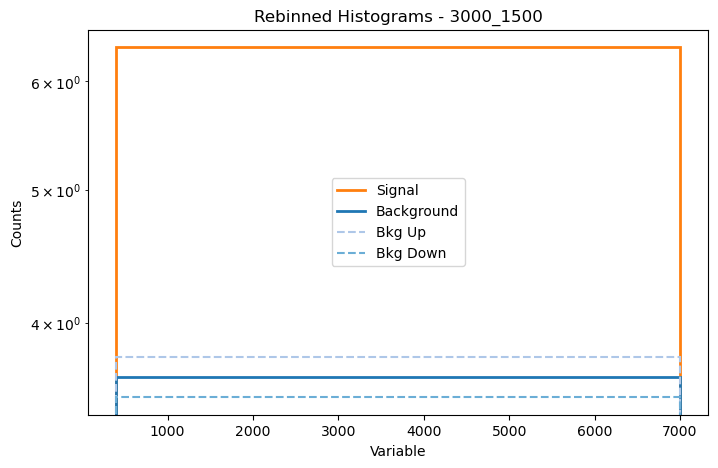

Plotting rebinned histograms for key: 2000_500


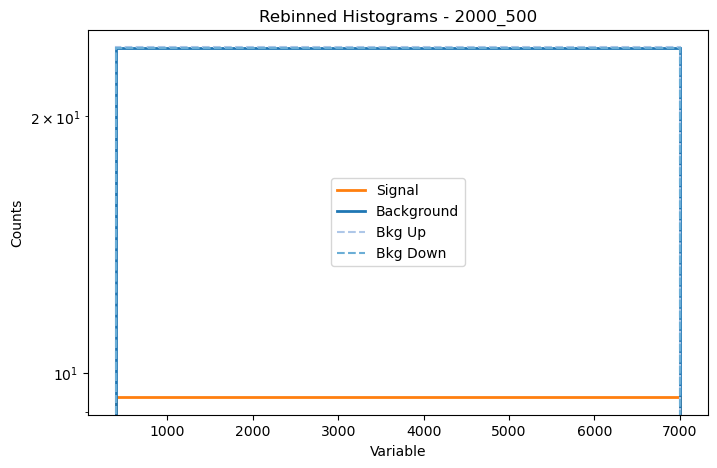

Plotting rebinned histograms for key: 3000_200


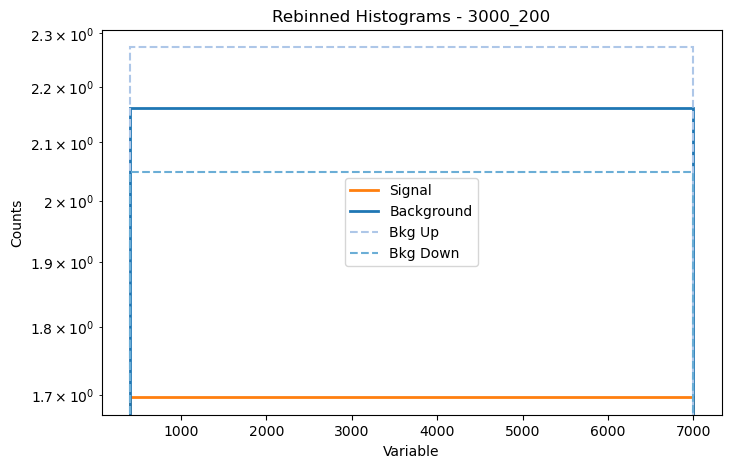

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 48.30577902821172
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 49.354021236857434
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 51.67060588146511
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 48.19095295383379
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.

/tmp/ipykernel_2234/1098717644.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  llrb = n_b/(np.sqrt(n_s))


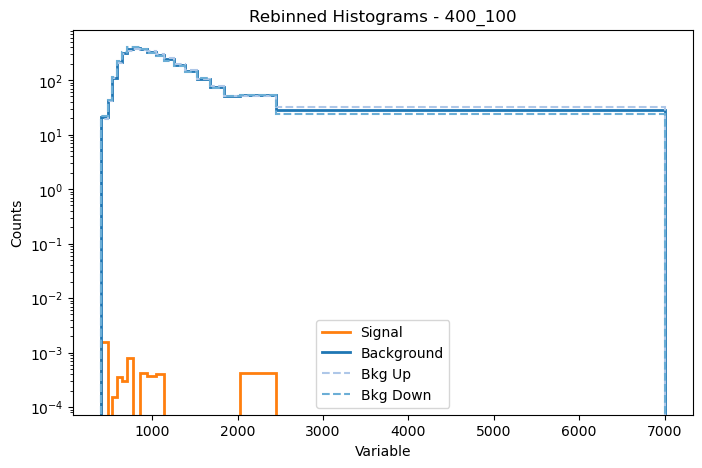

Z = 2.263573943266855, stat_unc_b = 0.1614018708573459, stat_unc_s = 0.5319334411436629
Z = 1.9482753558671675, stat_unc_b = 0.1739725538960936, stat_unc_s = 0.9187925077203913
Plotting rebinned histograms for key: 1500_500


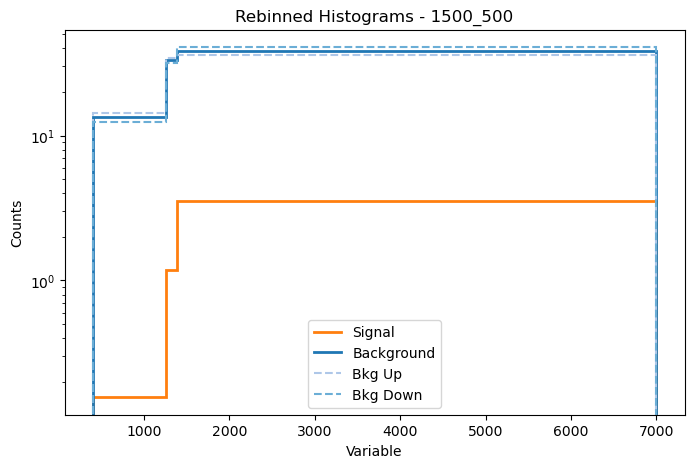

Plotting rebinned histograms for key: 6000_4000


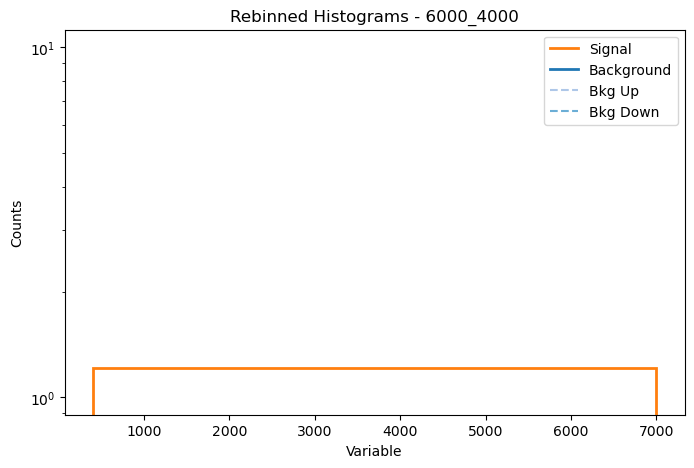

Plotting rebinned histograms for key: 6000_2000


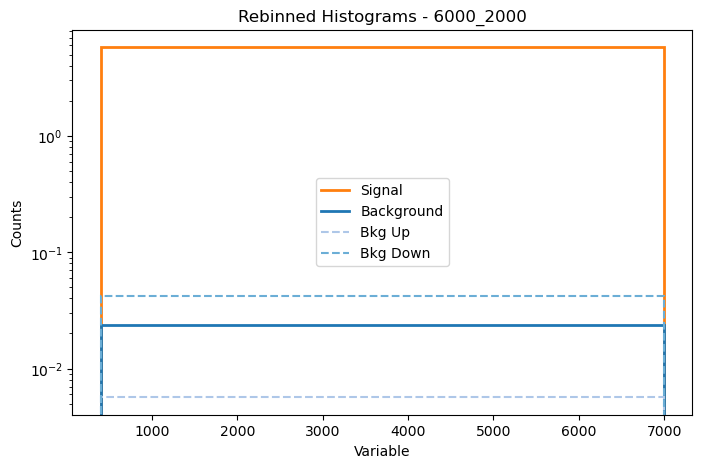

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 25.36806134643498
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 30.187884928562024
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 28.23002732350971
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 29.96785652095231
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 27.846726181994303
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 22.098522573377696
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 20.802779982556313
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 15.427493696966533
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 19.728468084963236
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 16.272827472575
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 7.031880899907199
Z = 0.5779855

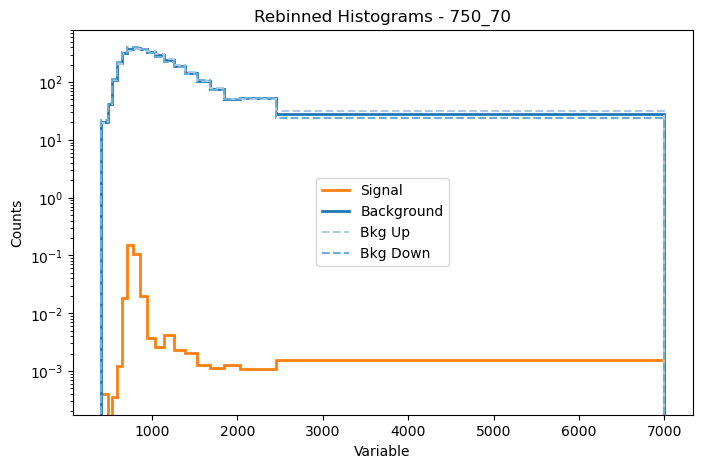

Z = 1.4060868126872363, stat_unc_b = 0.11806147943777603, stat_unc_s = 4.530890272627932
Z = 1.5927591343890437, stat_unc_b = 0.11092750284891428, stat_unc_s = 2.284593747322902
Z = 1.3479683474024065, stat_unc_b = 0.12057976732213152, stat_unc_s = 3.0545476998200036
Z = 0.6441485279541068, stat_unc_b = 0.17443003957878184, stat_unc_s = 5.893653911304569
Plotting rebinned histograms for key: 750_300


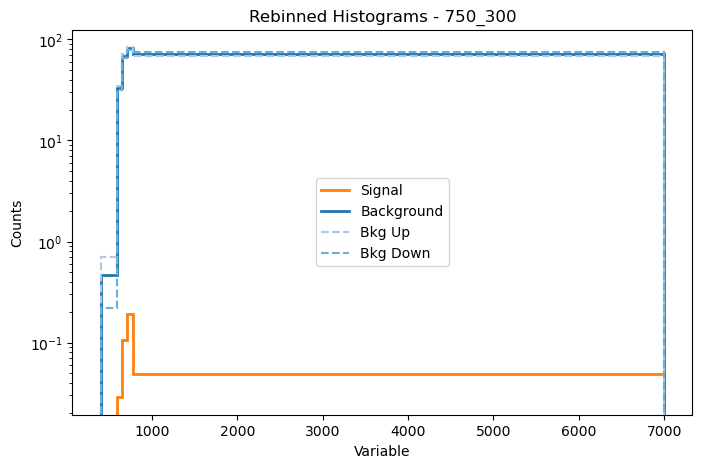

Plotting rebinned histograms for key: 3000_1000


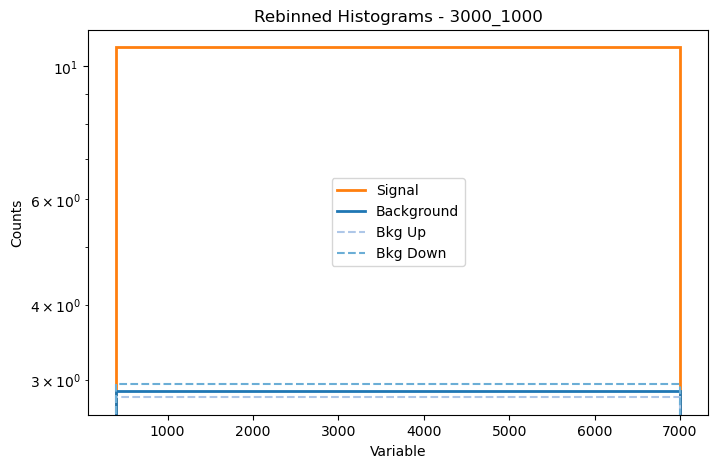

Plotting rebinned histograms for key: 6000_200


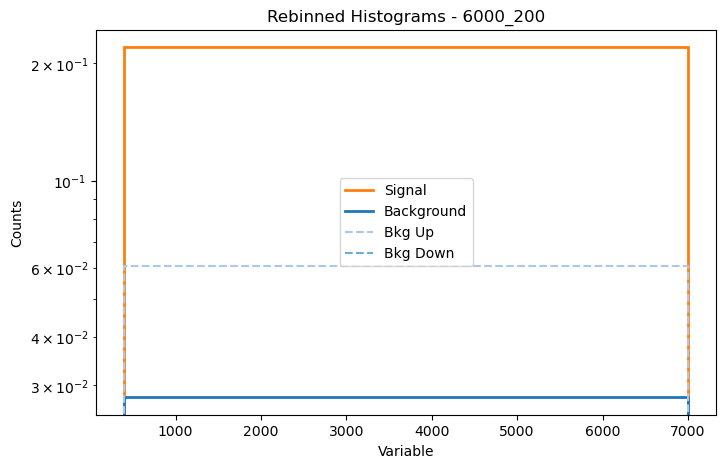

Plotting rebinned histograms for key: 2500_500


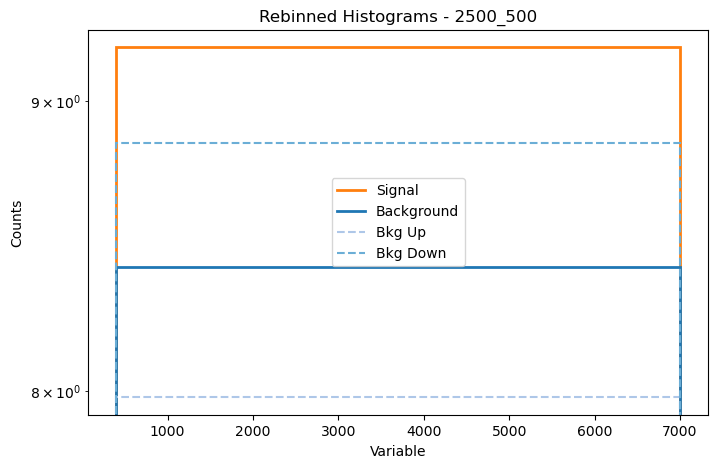

Z = 1.2109885500257684, stat_unc_b = 0.12128493535310068, stat_unc_s = 3.469543462512608
Z = 1.7013360215402629, stat_unc_b = 0.10232501827749094, stat_unc_s = 1.6937196011664326
Z = 1.5556795987902396, stat_unc_b = 0.10700813655349085, stat_unc_s = 2.4810185456421237
Z = 0.5319958296437295, stat_unc_b = 0.1829880653521516, stat_unc_s = 6.5221856497984305
Plotting rebinned histograms for key: 750_170


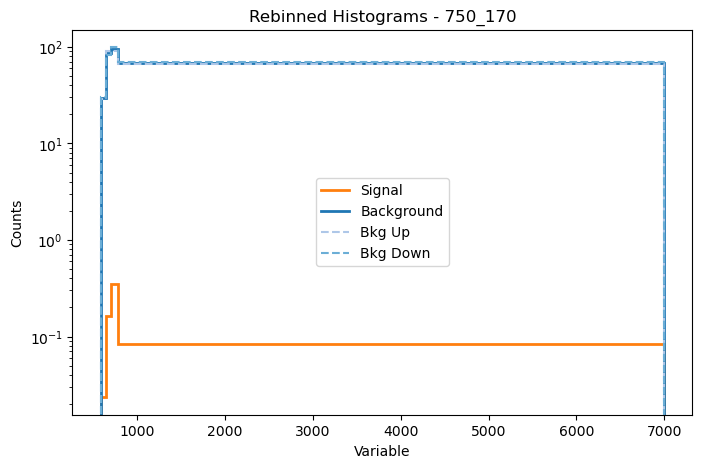

Plotting rebinned histograms for key: 6000_300


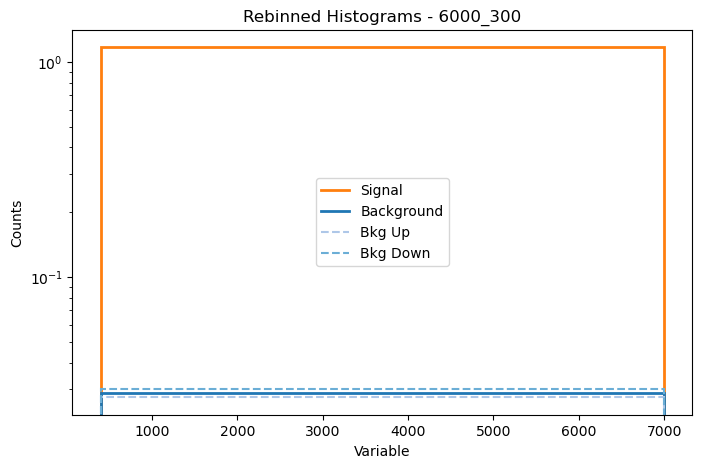

Plotting rebinned histograms for key: 3000_2500


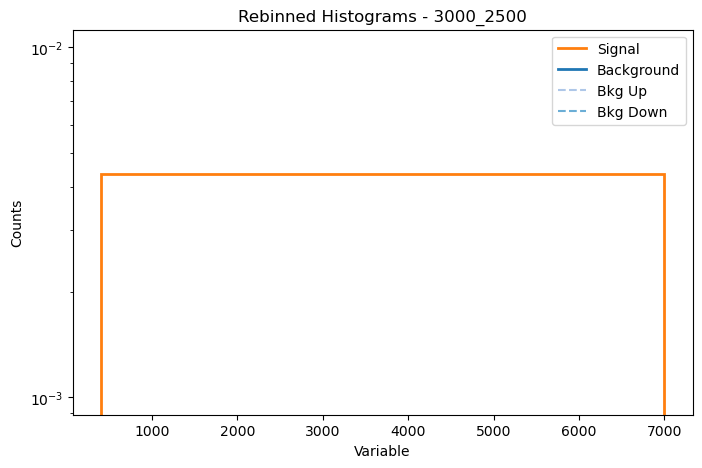

Plotting rebinned histograms for key: 2500_200


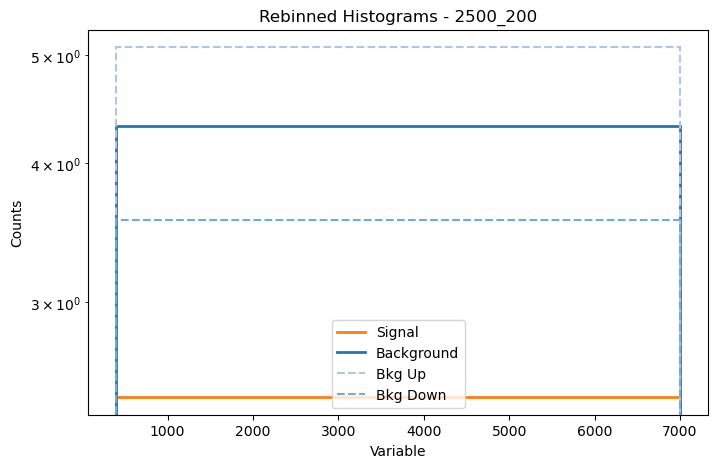

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 21.494184249675836
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 20.776469440308603
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 26.363509549709264
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 12.570056349438364
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 11.795363680676573
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 10.962215703822501
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 7.621087377223472
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 5.801256660943559
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 1.6423604387528412
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 1.2191001928207563
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 2.1646865379322597
Z = 0.57

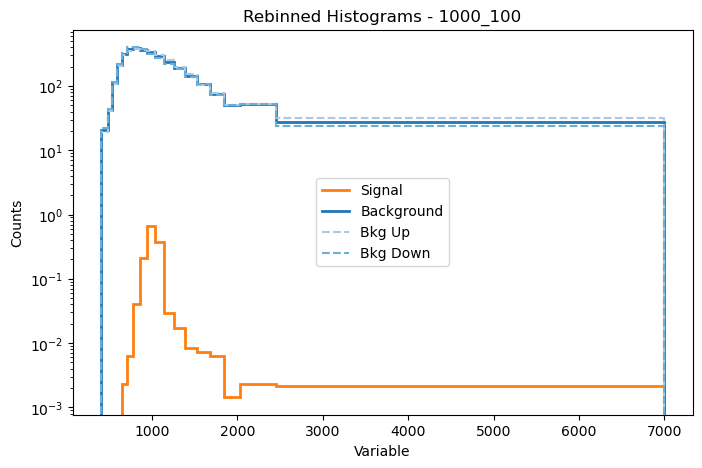

Z = 5.000000000000001, stat_unc_b = 0.1980432849852484, stat_unc_s = 0.3518554398821726
Plotting rebinned histograms for key: 2000_750


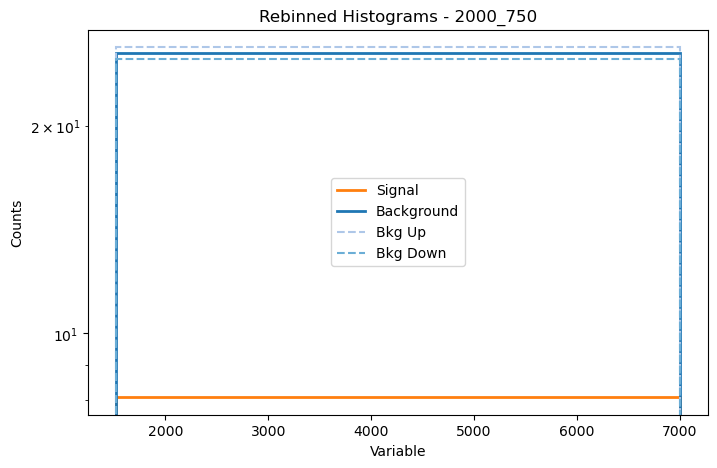

Plotting rebinned histograms for key: 4000_3000


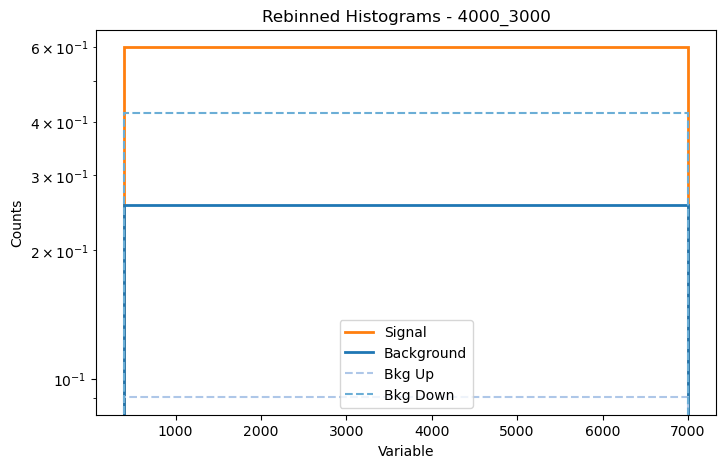

Plotting rebinned histograms for key: 4000_300


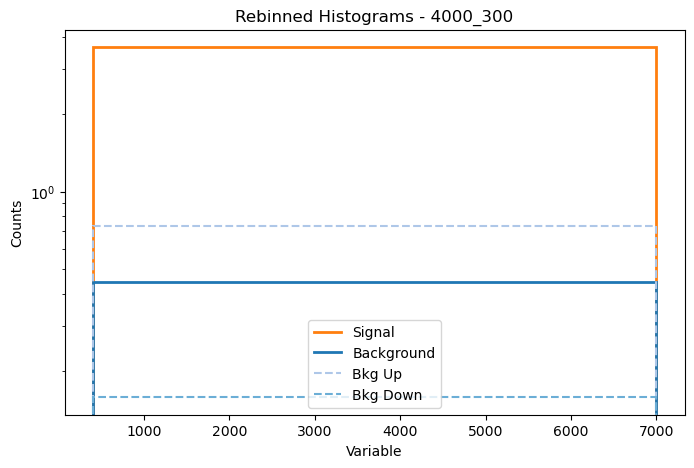

Z = 3.4747834305036274, stat_unc_b = 0.15611987768112545, stat_unc_s = 4.614380058032993
Plotting rebinned histograms for key: 750_400


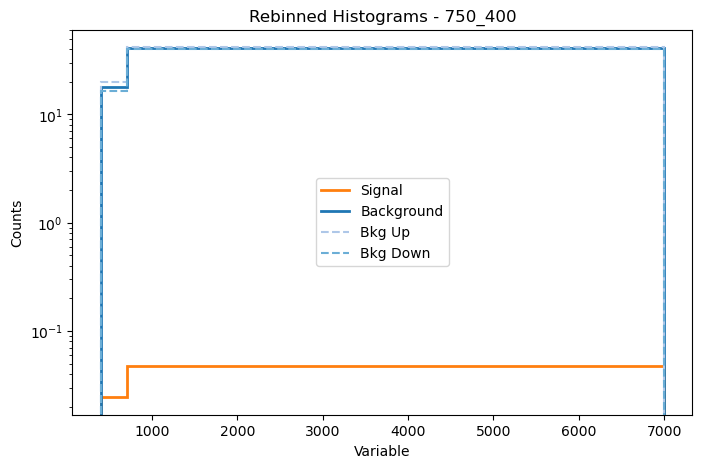

Plotting rebinned histograms for key: 2000_250


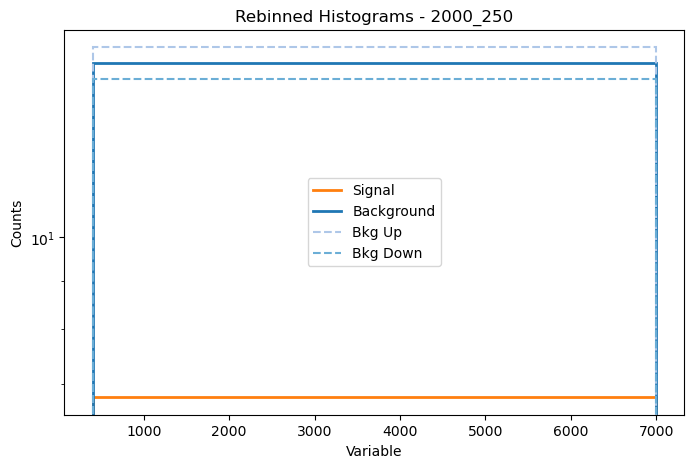

Plotting rebinned histograms for key: 5000_3000


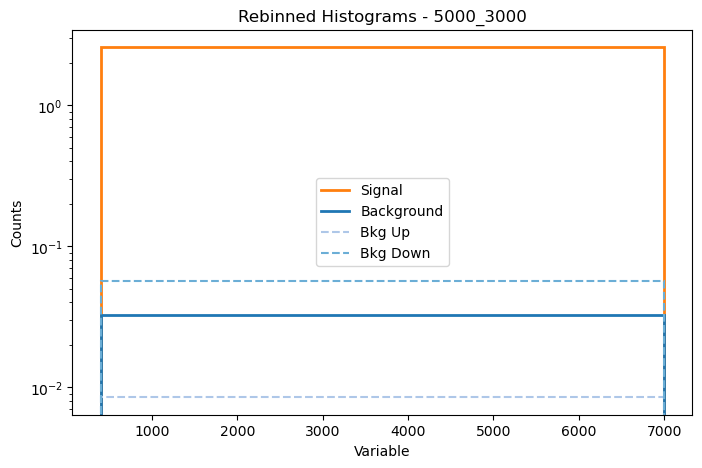

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 106.94129986357481
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_s = inf
Z = 0.

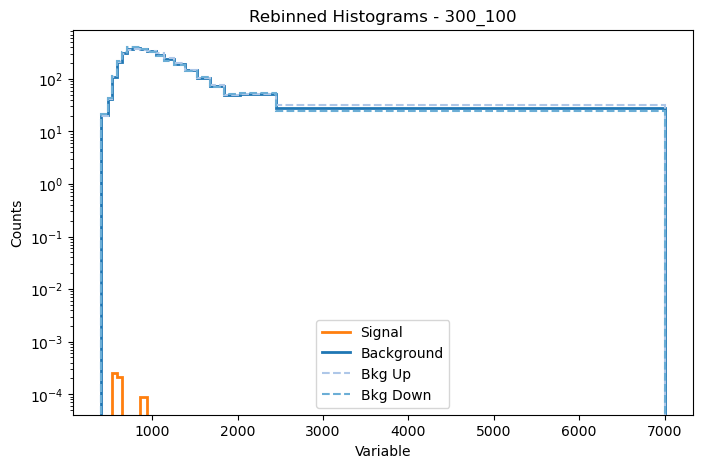

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 1.5330484270924798
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 8.872323033326516
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 18.881140508259584
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.0516535882618

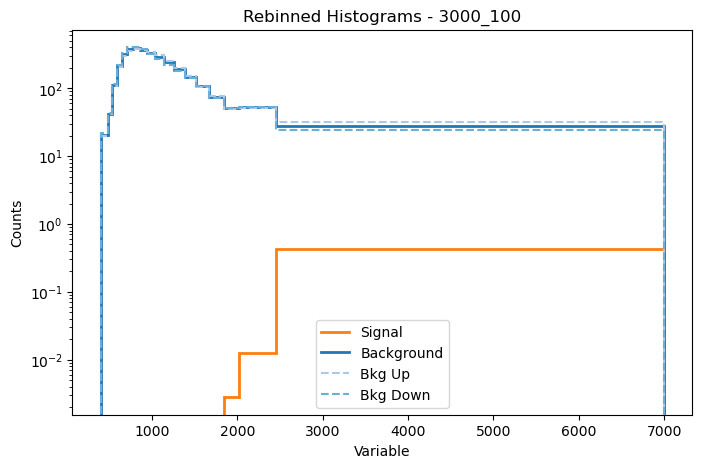

Z = 2.6012069442447316, stat_unc_b = 0.17197280130312478, stat_unc_s = 0.5164114522711305
Z = 1.954563304930487, stat_unc_b = 0.19839117403421672, stat_unc_s = 1.003861358608378
Plotting rebinned histograms for key: 1500_300


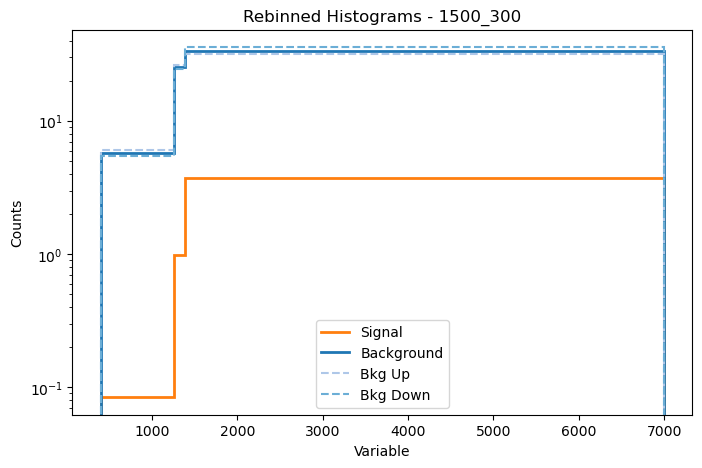

Plotting rebinned histograms for key: 2000_170


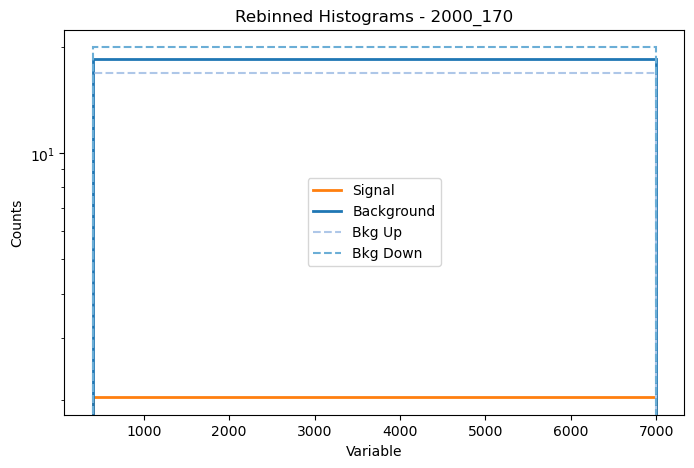

Z = 0.8909788207104202, stat_unc_b = 0.16565456387210364, stat_unc_s = 2.7038566773310455
Z = 1.5739845195752662, stat_unc_b = 0.12463409582945896, stat_unc_s = 1.174288512117674
Z = 1.823815444920339, stat_unc_b = 0.1157834940014597, stat_unc_s = 1.6525493892408465
Z = 0.7112212147939739, stat_unc_b = 0.1854106790390397, stat_unc_s = 4.3750385646732335
Plotting rebinned histograms for key: 1000_250


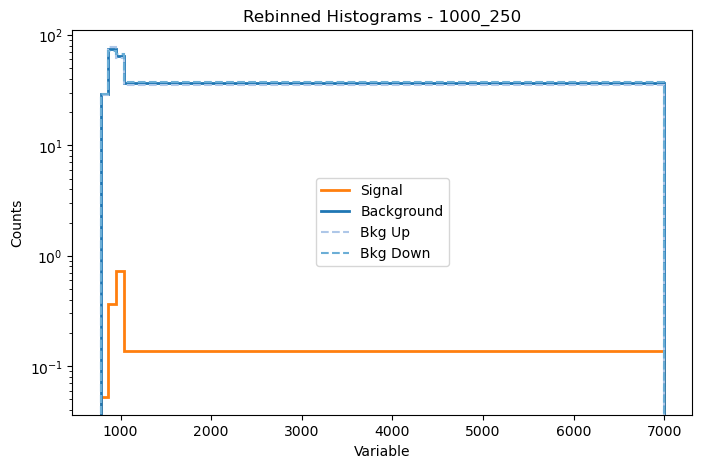

Plotting rebinned histograms for key: 4000_2000


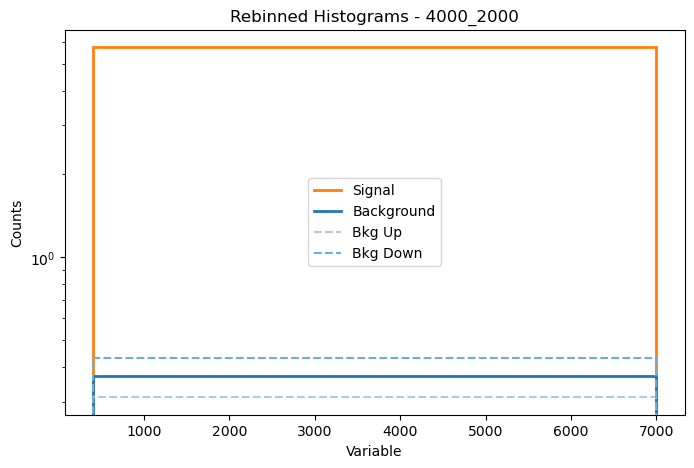

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 7.547796944698973
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 6.382810547746901
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 6.1685118600885565
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 3.773414268041964
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 1.652761811514495
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 1.5826825508749194
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 2.8266961730194944
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 5.704458584316618
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 10.379103822060543
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05

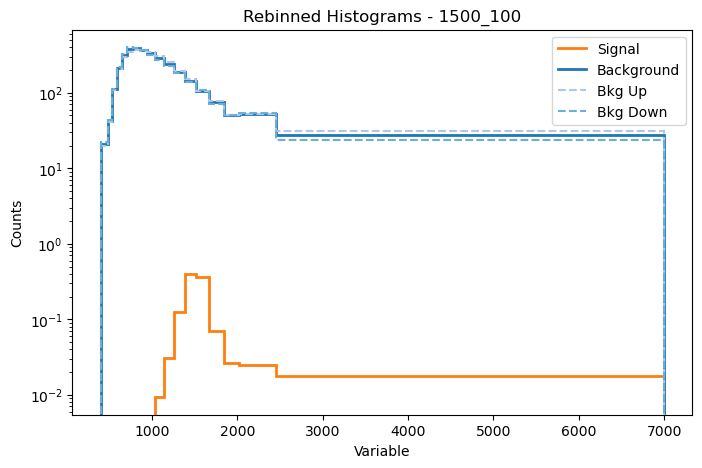

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 1.6364818924305662
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 2.482162198004261
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 8.518951540454802
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 23.333939641665243
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 35.147219022115834
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572,

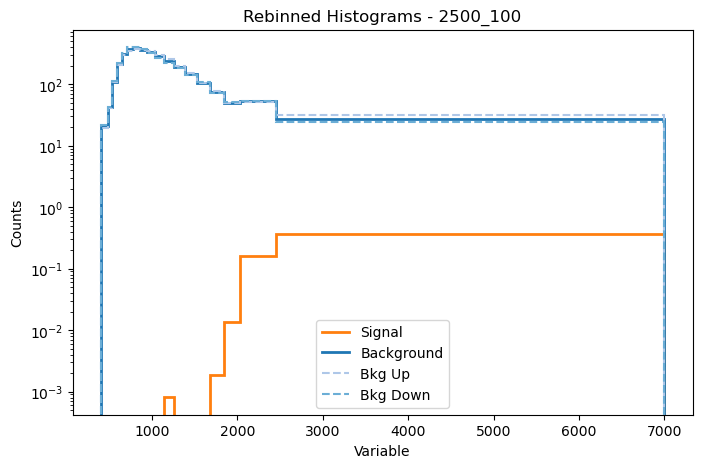

Z = 1.3220043662123548, stat_unc_b = 0.1800288981068649, stat_unc_s = 2.441308544771753
Z = 1.8406338505391286, stat_unc_b = 0.15257204442900216, stat_unc_s = 3.608721524407178
Z = 1.1298036793780253, stat_unc_b = 0.19474090131461713, stat_unc_s = 10.175254602663408
Plotting rebinned histograms for key: 1500_1000


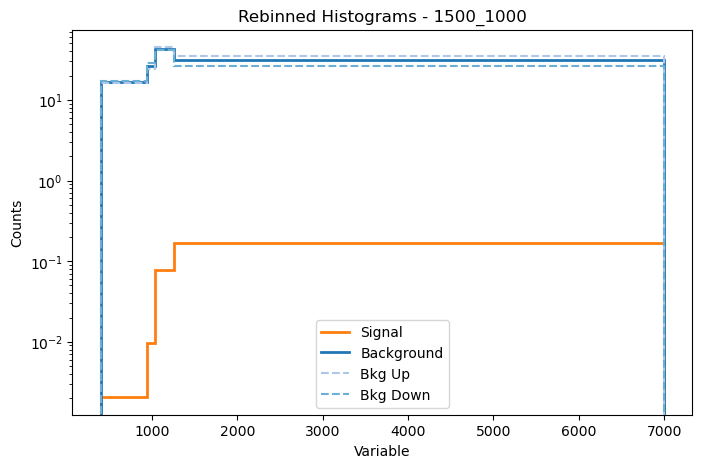

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 1.6540564685590171
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 8.922191796713298
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 23.326585202881954
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.0516535882618

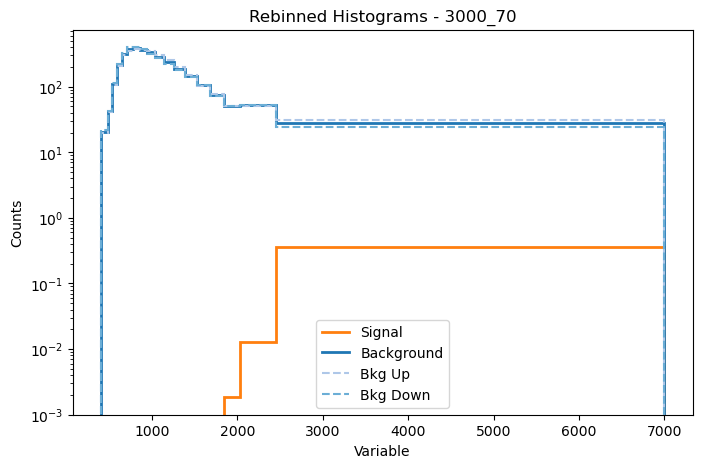

Plotting rebinned histograms for key: 5000_4000


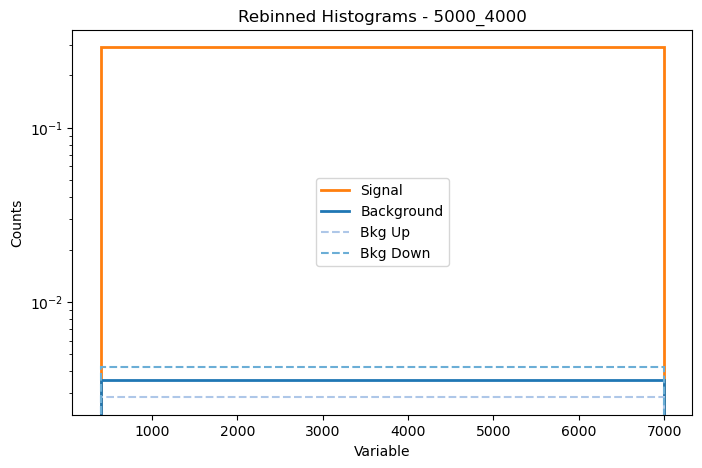

Z = 2.9164873914388827, stat_unc_b = 0.184745379952416, stat_unc_s = 0.6038596631802905
Plotting rebinned histograms for key: 1500_200


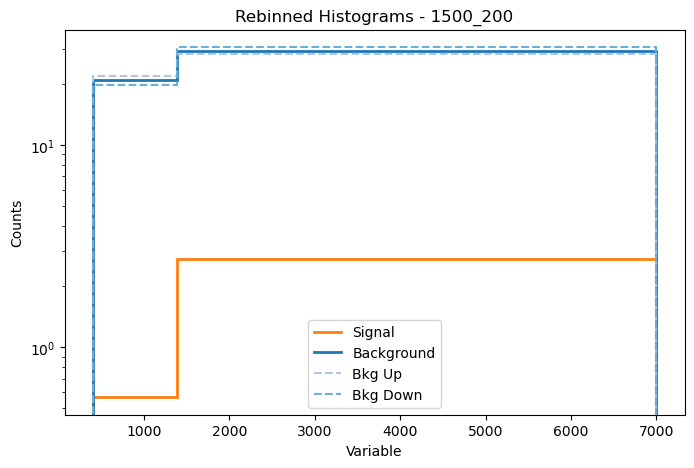

Z = 0.9268887815328858, stat_unc_b = 0.15928466411803663, stat_unc_s = 2.6033448814120215
Z = 1.5000137061127932, stat_unc_b = 0.1252103308960541, stat_unc_s = 1.314050904200235
Z = 1.7349561448464388, stat_unc_b = 0.1164242707286754, stat_unc_s = 1.8932390176558072
Z = 0.838141367507883, stat_unc_b = 0.16750552593074627, stat_unc_s = 4.615636594898449
Plotting rebinned histograms for key: 1000_200


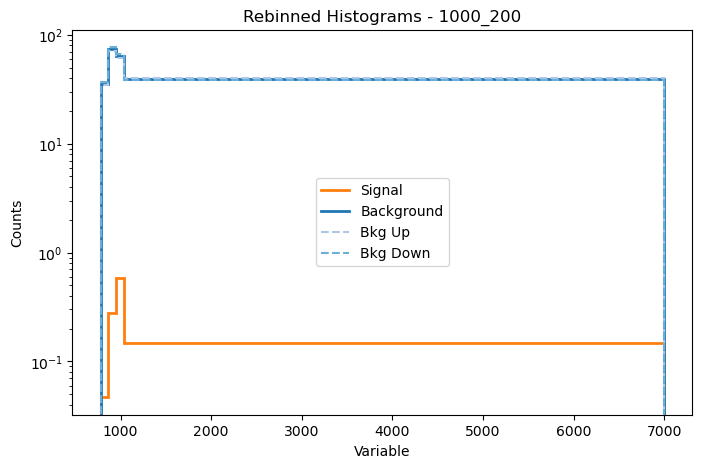

Z = 1.7671469624202736, stat_unc_b = 0.19579241472777445, stat_unc_s = 1.0570531357260977
Z = 3.2328530375797264, stat_unc_b = 0.144756880545085, stat_unc_s = 1.3302482575129064
Plotting rebinned histograms for key: 1500_750


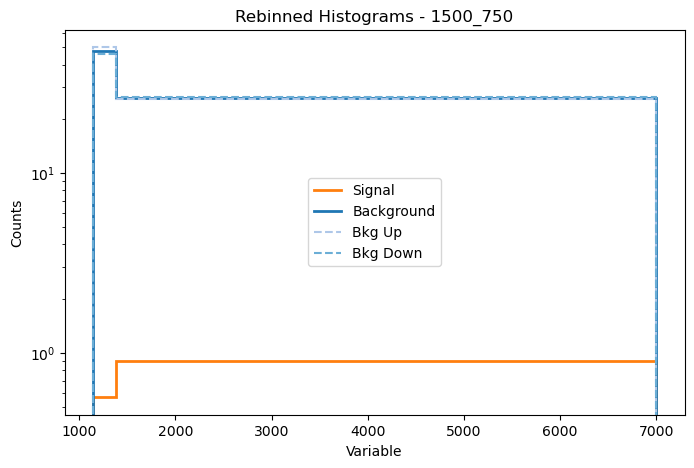

Plotting rebinned histograms for key: 6000_500


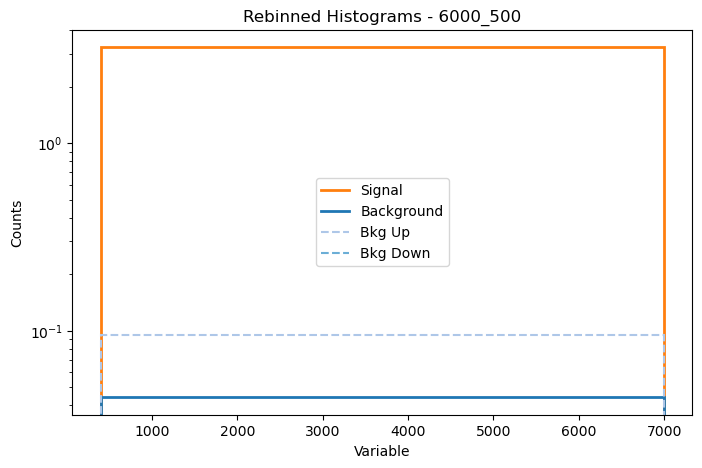

Z = 0.8925966681731524, stat_unc_b = 0.1603584811407812, stat_unc_s = 2.6973787451472924
Z = 1.3744570714627569, stat_unc_b = 0.12922721200444776, stat_unc_s = 1.360749898852816
Z = 1.6407350208214155, stat_unc_b = 0.11827701098373983, stat_unc_s = 1.9017603436776023
Z = 1.092211239542675, stat_unc_b = 0.14496602950586032, stat_unc_s = 4.173097341754365
Plotting rebinned histograms for key: 1000_170


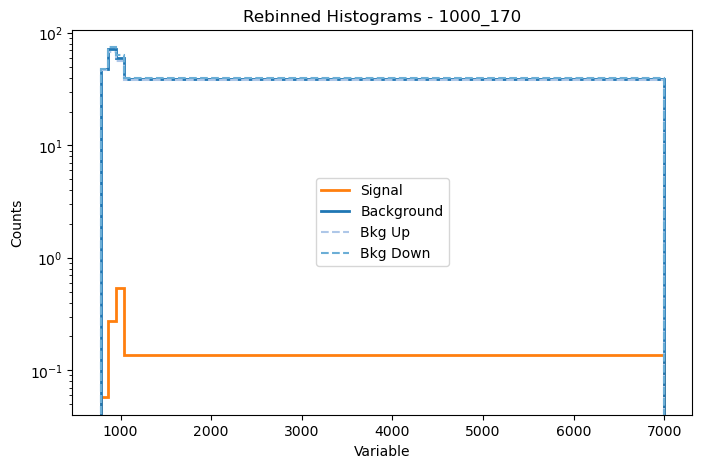

Plotting rebinned histograms for key: 2000_200


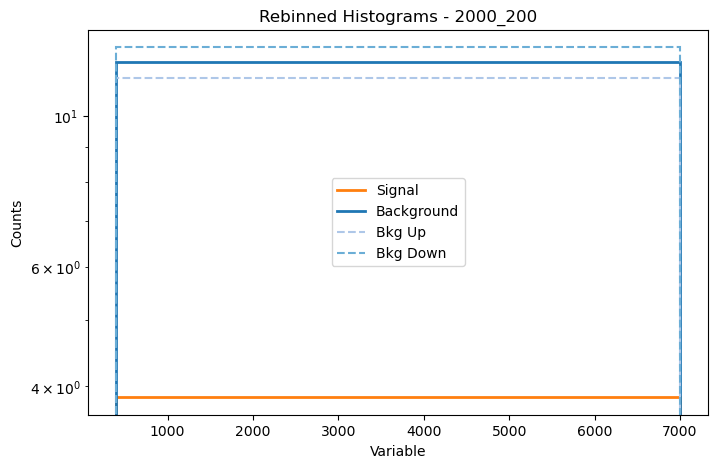

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 3.5821781911593713
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 1.9181954915798558
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 2.131795978942497
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 4.036412046260727
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 6.139907717004966
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 10.517466095967373
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 14.995427064681271
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s 

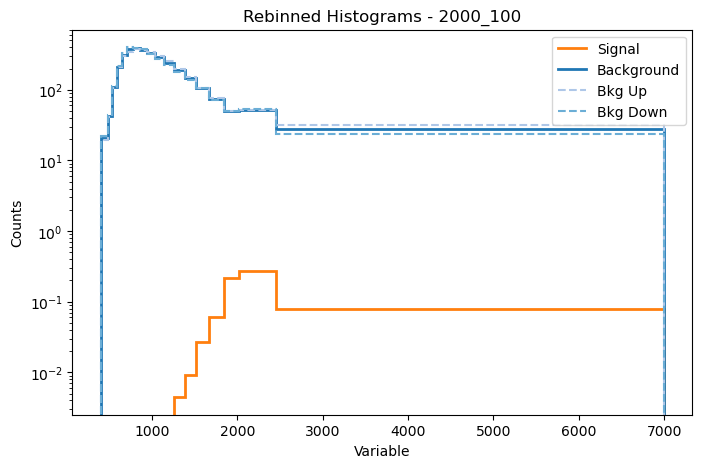

Z = 0.7694553402225683, stat_unc_b = 0.15145655013145262, stat_unc_s = 3.3630309729130157
Z = 1.1808675580024133, stat_unc_b = 0.12225853111829851, stat_unc_s = 1.4369785341292731
Z = 1.453562231794878, stat_unc_b = 0.11019527023763567, stat_unc_s = 1.7050843073119188
Z = 1.340746717076868, stat_unc_b = 0.1147377682465251, stat_unc_s = 3.3695820071424833
Plotting rebinned histograms for key: 1000_400


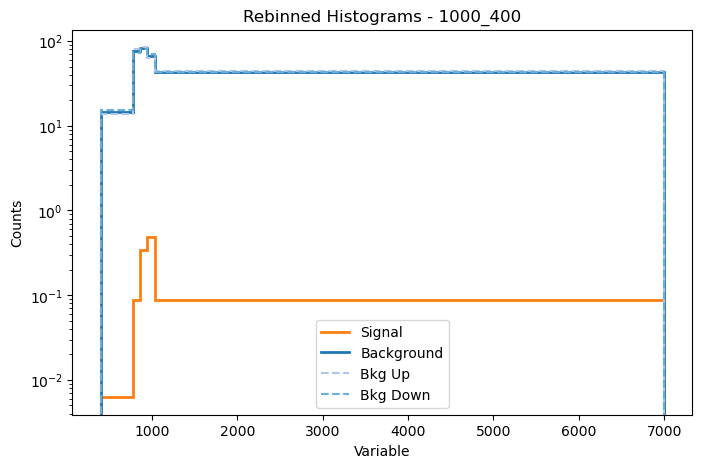

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 69.43853496218496
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 57.03346478032182
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_s

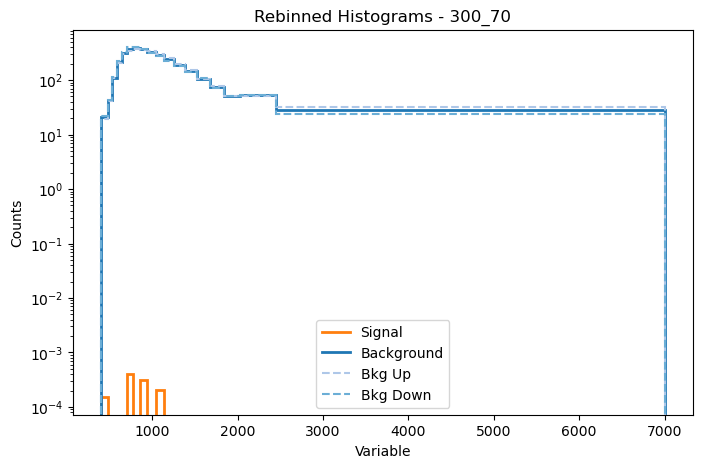

Z = 0.8278290398949634, stat_unc_b = 0.15810818792044773, stat_unc_s = 2.8499587489670466
Z = 1.3558791457207549, stat_unc_b = 0.1235418781172696, stat_unc_s = 1.2394900017814365
Z = 1.6270318159010244, stat_unc_b = 0.11277859169846578, stat_unc_s = 1.623022695839547
Z = 1.1892599984832575, stat_unc_b = 0.13191260115106698, stat_unc_s = 3.4180434749663267
Plotting rebinned histograms for key: 1000_300


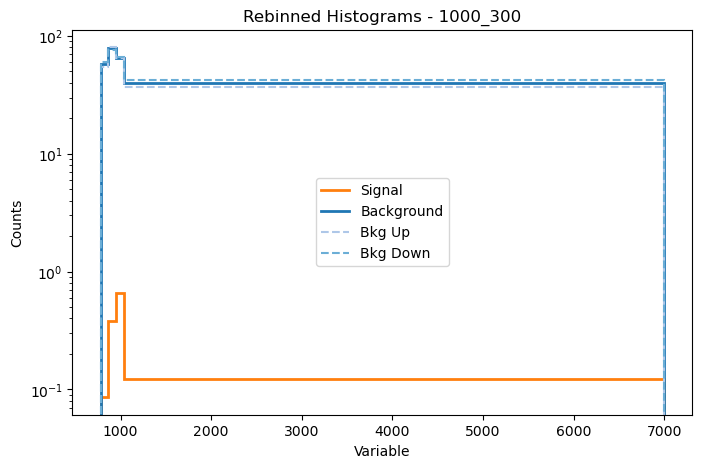

Z = 2.7500413922194475, stat_unc_b = 0.18322905812973492, stat_unc_s = 0.6879982571049545
Plotting rebinned histograms for key: 1500_170


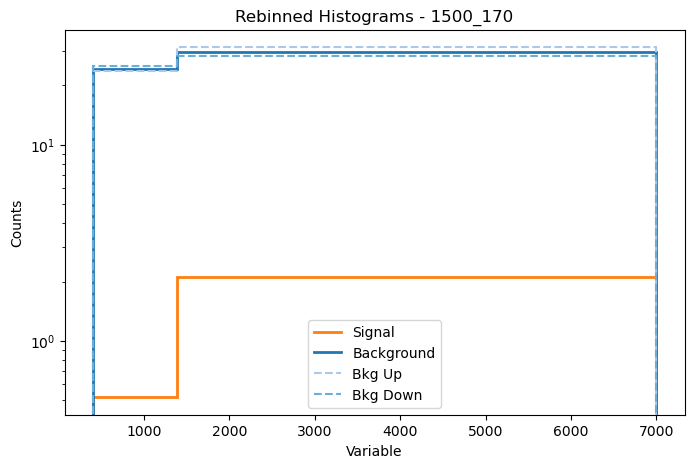

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 29.733024390383626
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 35.66077440337191
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 18.25984342634571
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 26.460243022061675
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 19.618723195395567
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 13.726390368135329
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 17.218907421299953
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 6.972623160895756
Z = 0.5779855639351648, stat_unc_b = 0.050916437915899

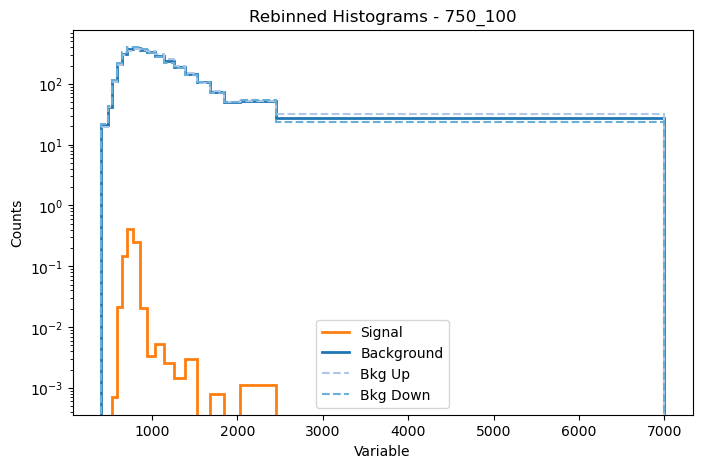

Plotting rebinned histograms for key: 2500_300


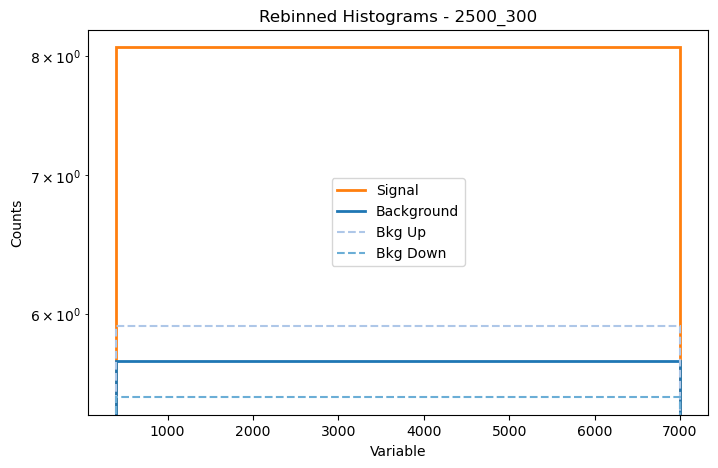

Plotting rebinned histograms for key: 2000_400


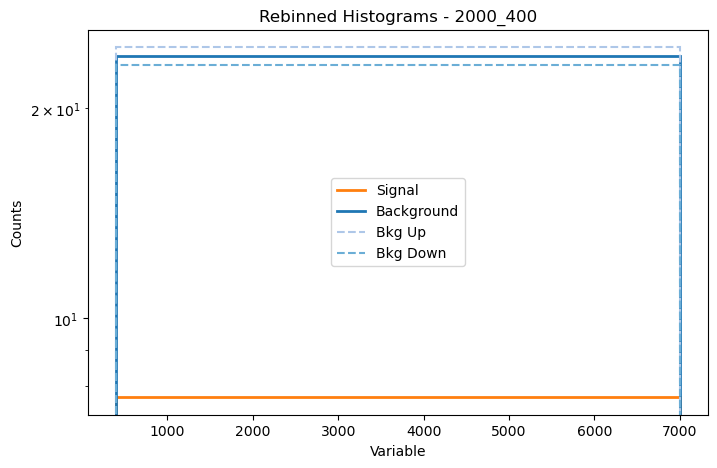

Z = 0.04112913740991109, stat_unc_b = 0.19087988101411985, stat_unc_s = 5.735228586962007
Z = 0.07879286276129256, stat_unc_b = 0.13790865290779314, stat_unc_s = 16.240659982211437
Z = 0.07538848028137528, stat_unc_b = 0.14098810130364753, stat_unc_s = 16.85245811452937
Z = 0.11170622846590886, stat_unc_b = 0.11582338726043376, stat_unc_s = 28.58375674608445
Z = 0.15896942979888032, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21750887516985662, stat_unc_b = 0.0830035113502326, stat_unc_s = 29.25027944631755
Z = 0.2836658524370778, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583513553414775, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43268823699246334, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49946334693118033, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5509254366712137, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5780346680971551, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616540821171547, s

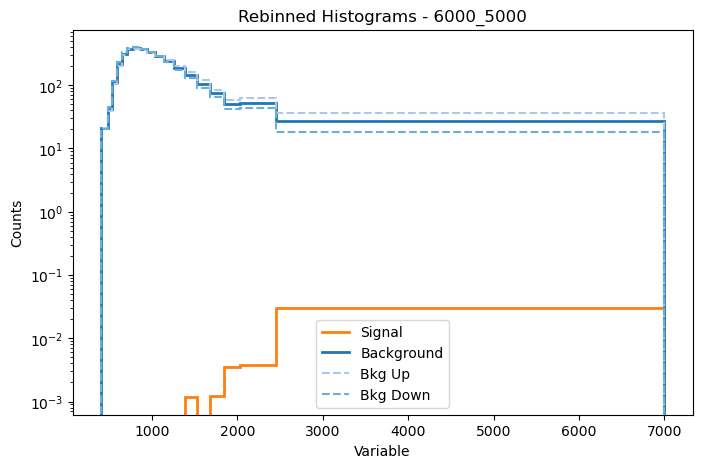

Plotting rebinned histograms for key: 4000_500


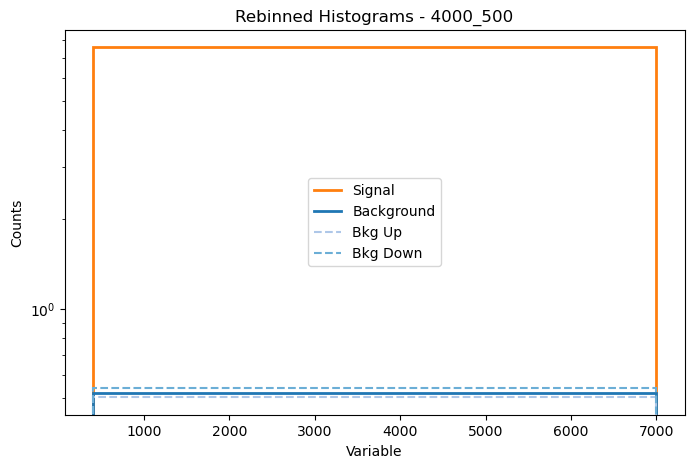

Plotting rebinned histograms for key: 2500_2000


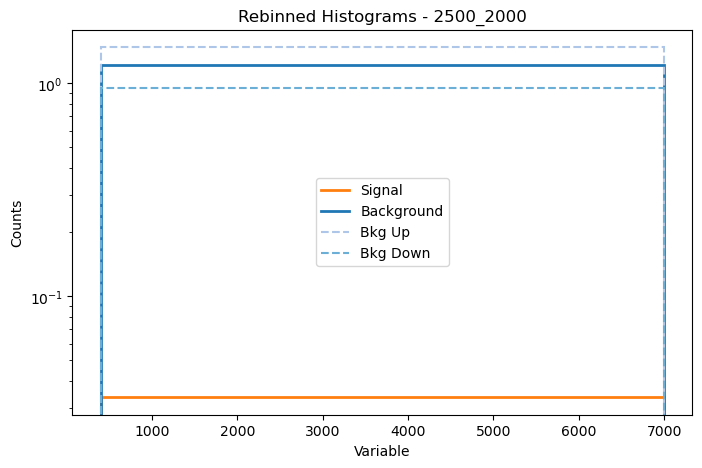

Z = 0.6542451476951839, stat_unc_b = 0.17457123523358978, stat_unc_s = 4.849562178208166
Z = 0.9644731913830058, stat_unc_b = 0.14377979492845816, stat_unc_s = 2.00964662717745
Z = 1.233668470150674, stat_unc_b = 0.12712872969876718, stat_unc_s = 2.269646232593352
Z = 1.276752255425975, stat_unc_b = 0.12496535383201952, stat_unc_s = 3.4122745274355357
Z = 0.8434275636276831, stat_unc_b = 0.15375138801754618, stat_unc_s = 5.7106552437060305
Plotting rebinned histograms for key: 1000_500


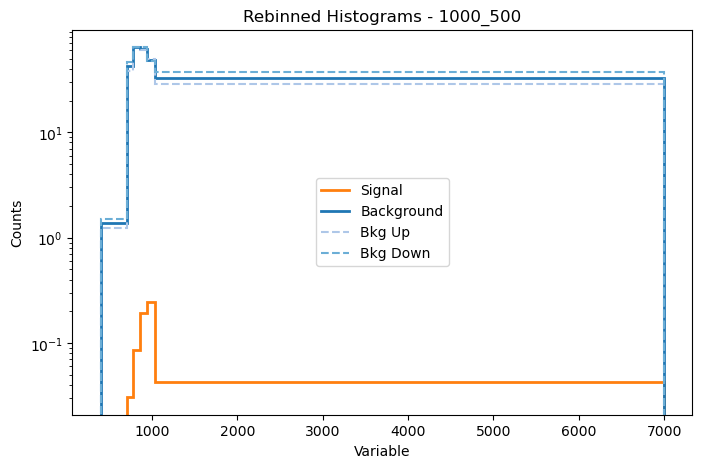

Plotting rebinned histograms for key: 3000_500


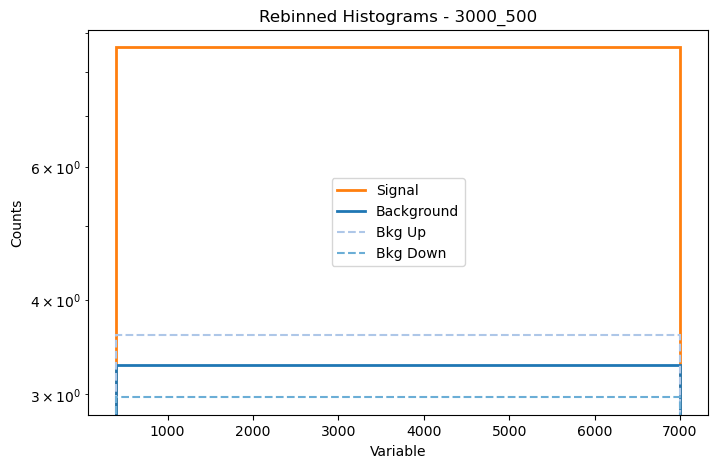

Plotting rebinned histograms for key: 2500_250


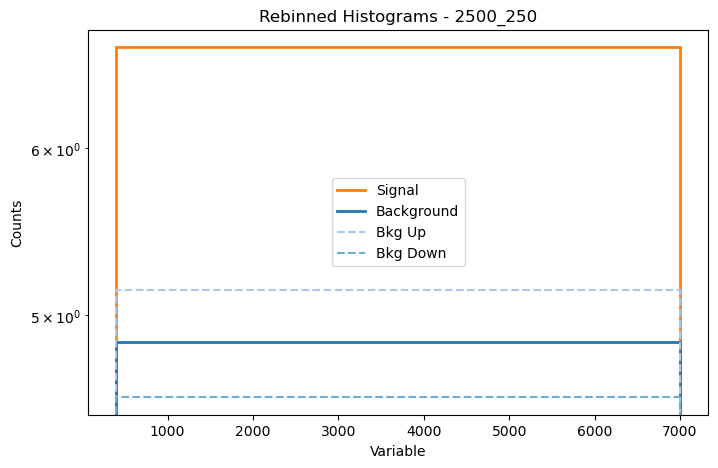

Z = 2.7152458747659285, stat_unc_b = 0.17856446588620212, stat_unc_s = 0.5237596387282394
Z = 2.2847541252340715, stat_unc_b = 0.19466141918011767, stat_unc_s = 1.0562583281234277
Plotting rebinned histograms for key: 1500_250


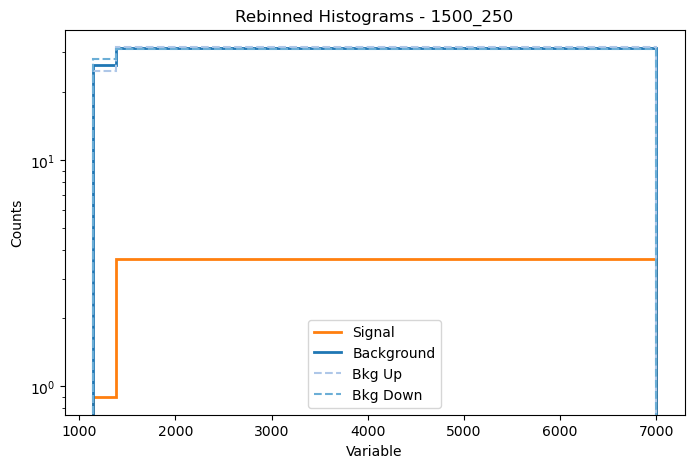

Plotting rebinned histograms for key: 6000_1000


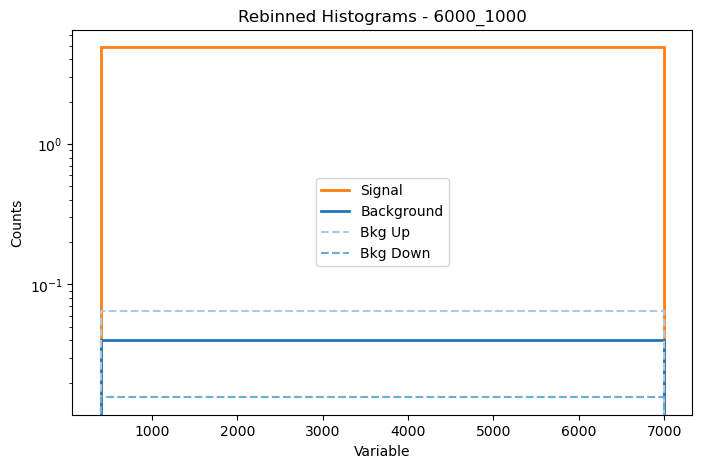

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_s = 47.45898098691013
Z = 0.4

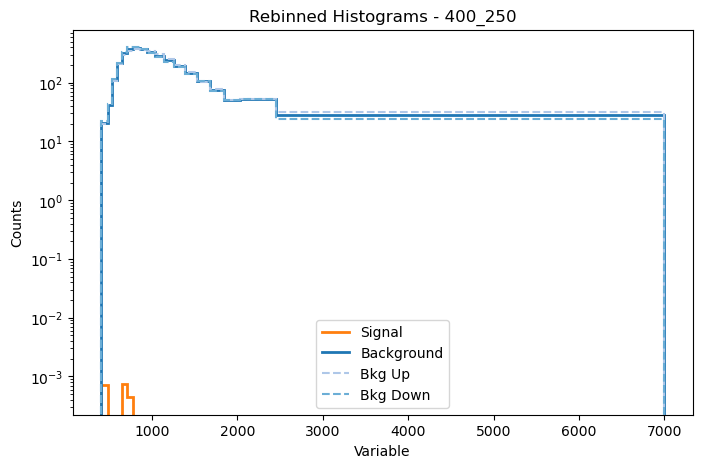

Plotting rebinned histograms for key: 2000_1500


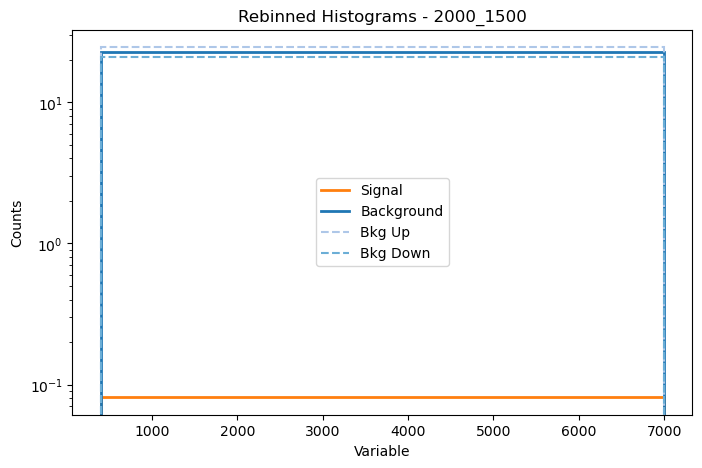

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 84.91606851605229
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = 80.12370640188193
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_s

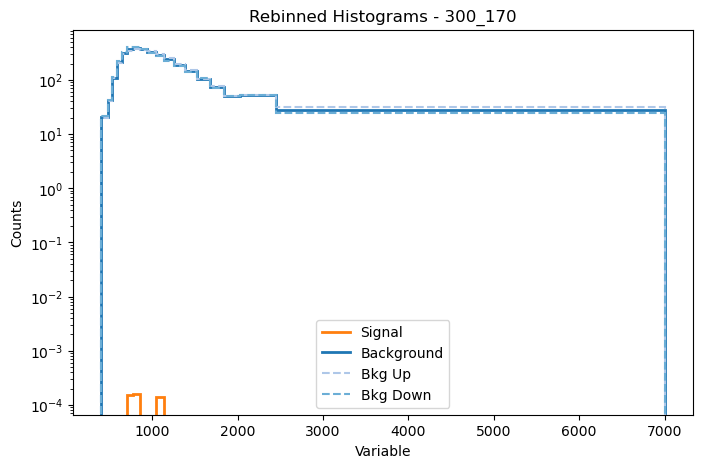

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 51.325887242579846
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 55.739217089725486
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc

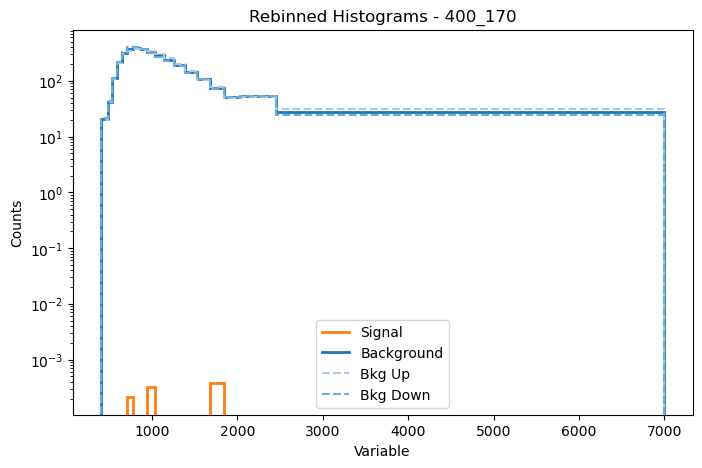

Plotting rebinned histograms for key: 5000_500


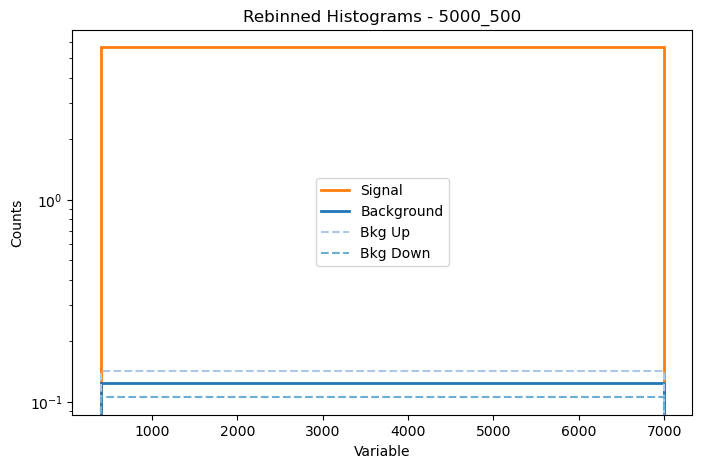

Plotting rebinned histograms for key: 4000_1000


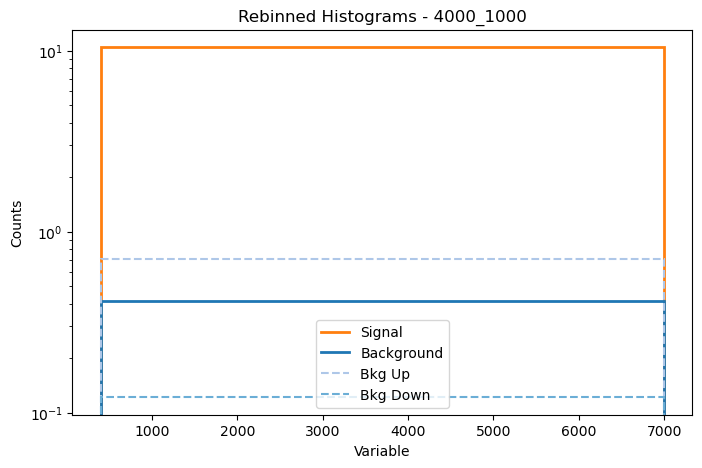

Plotting rebinned histograms for key: 3000_300


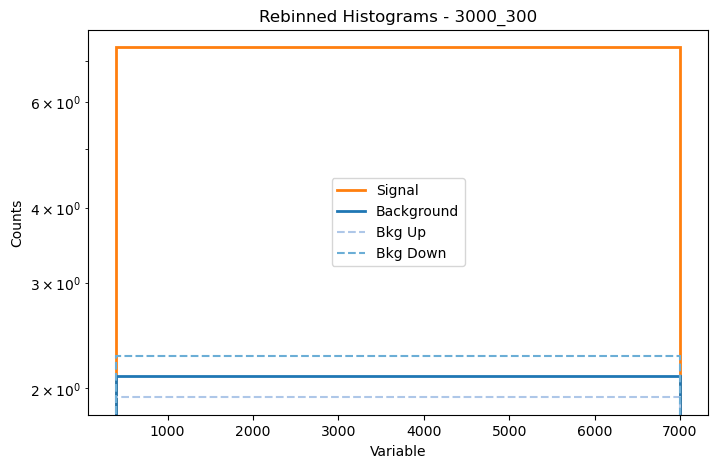

Plotting rebinned histograms for key: 3000_170


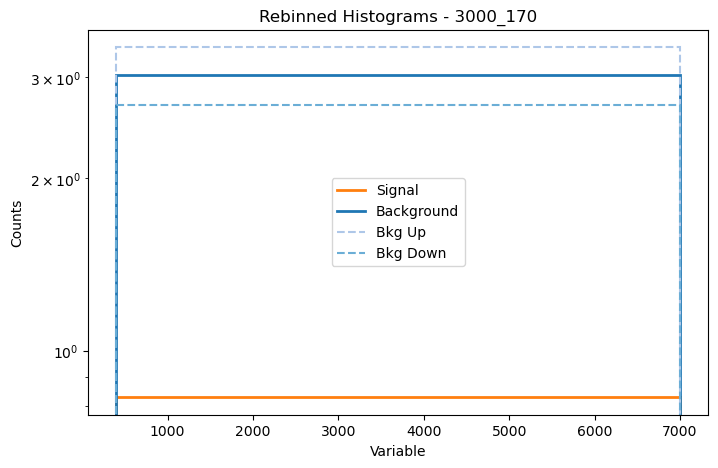

Plotting rebinned histograms for key: 2500_400


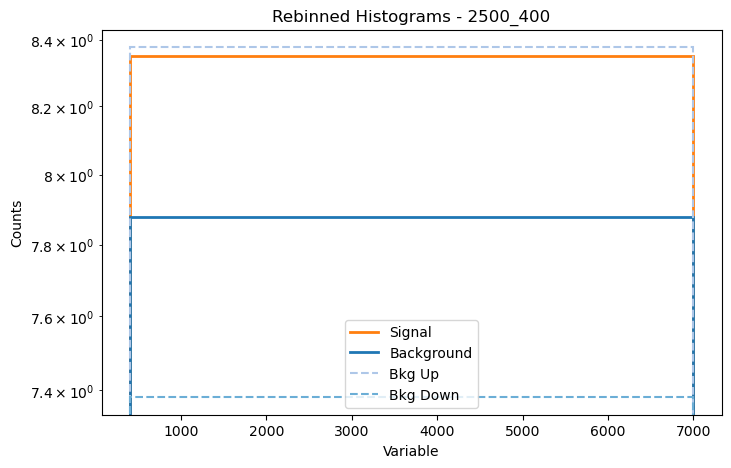

Z = 4.743626215001421, stat_unc_b = 0.19319064650380688, stat_unc_s = 0.4628327012978729
Plotting rebinned histograms for key: 2000_1000


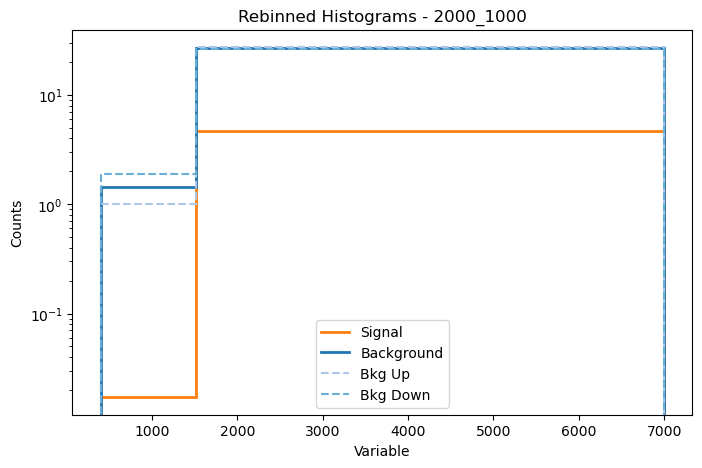

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 1.8120075110294018
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 3.363789696031001
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 10.574070782707953
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 59.640944778319906
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 

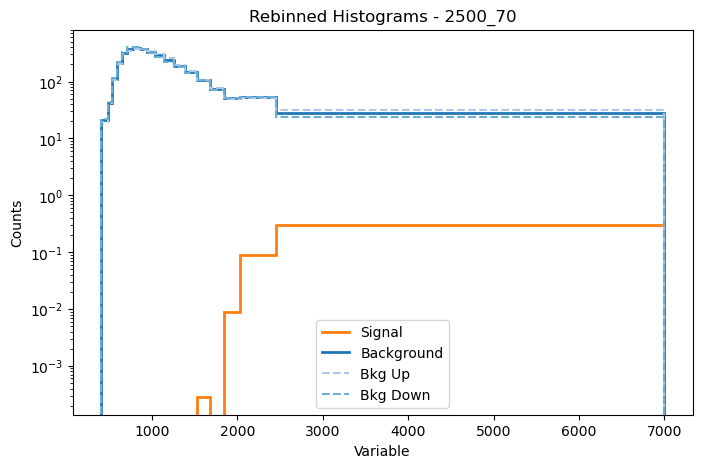

Plotting rebinned histograms for key: 5000_300


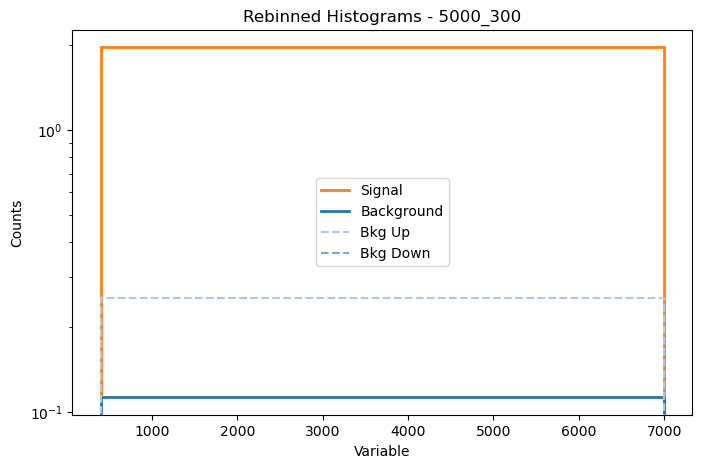

Plotting rebinned histograms for key: 2500_170


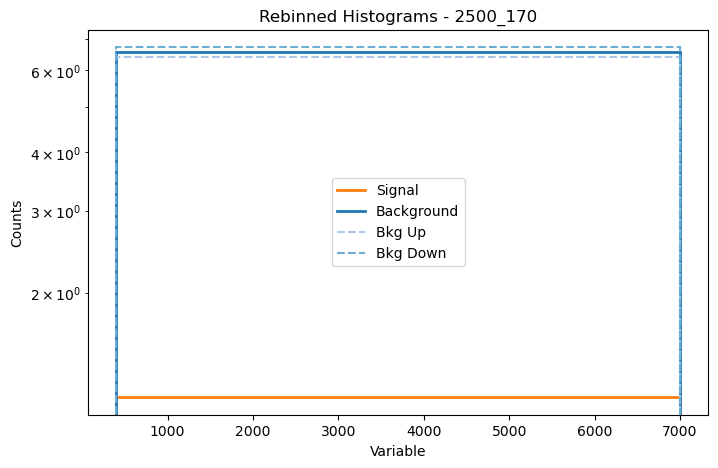

Plotting rebinned histograms for key: 3000_750


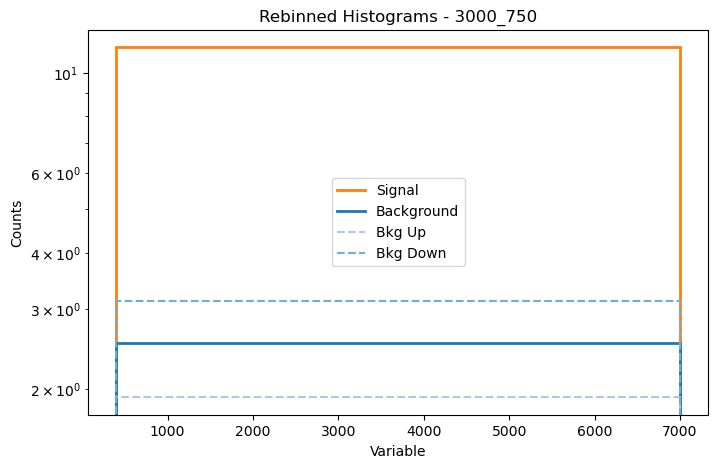

Plotting rebinned histograms for key: 2500_1500


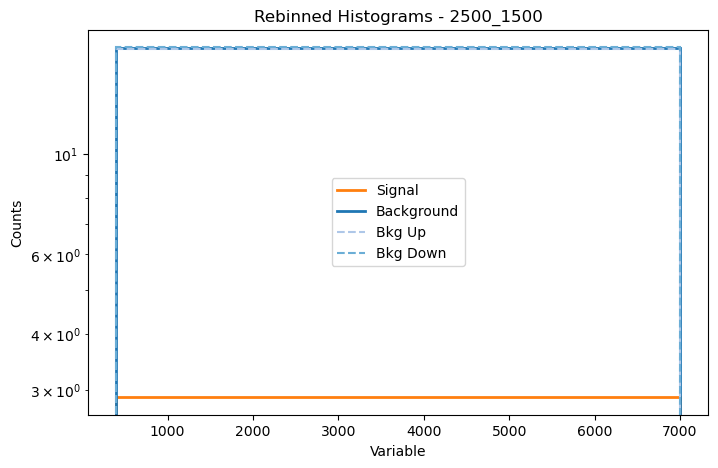

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 1.7821990933253633
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 21.959750671910644
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc

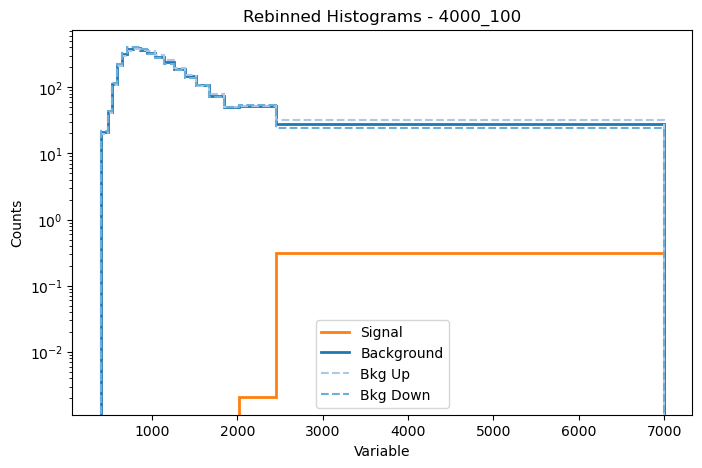

Plotting rebinned histograms for key: 3000_250


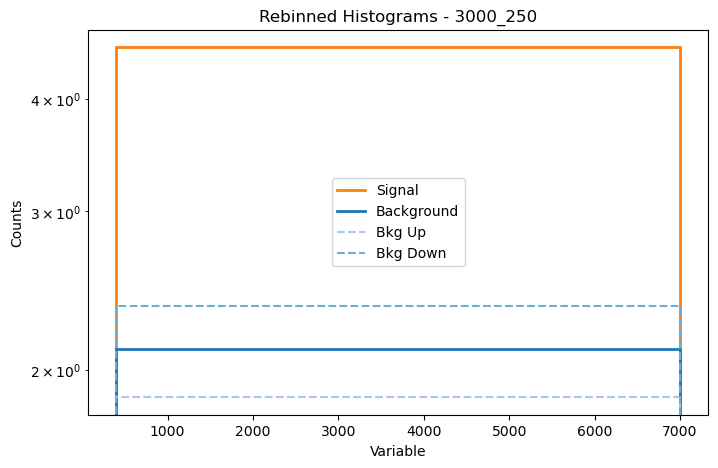

Plotting rebinned histograms for key: 2000_300


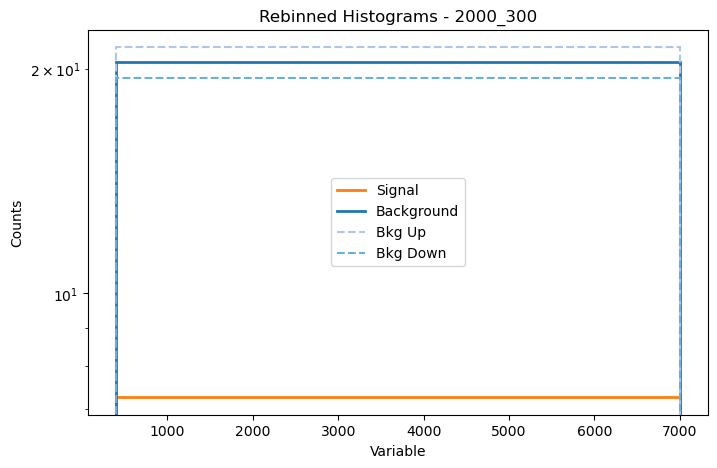

Plotting rebinned histograms for key: 5000_2000


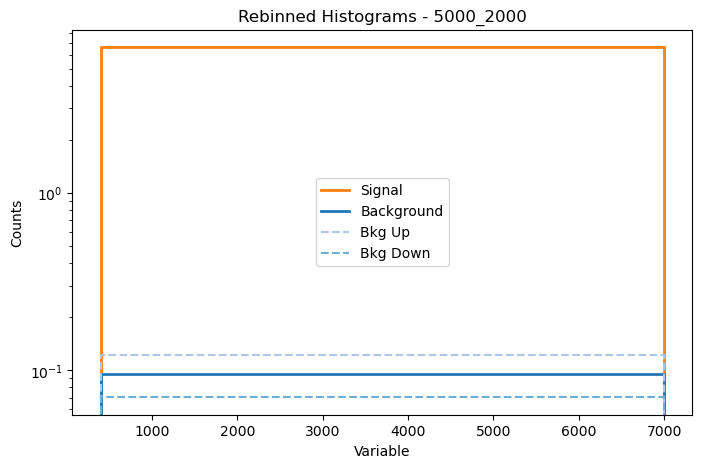

Plotting rebinned histograms for key: 3000_2000


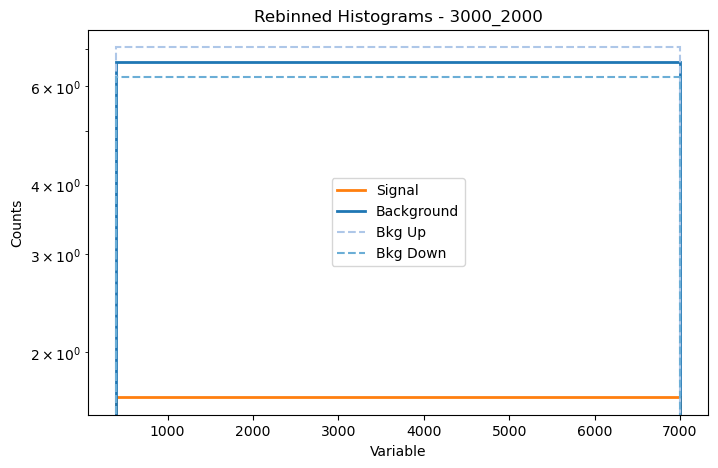

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 49.84043295740437
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 50.24571722452511
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 36.94871312294515
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 49.08449224331592
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 41.67341499374922
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = 48.8530281944537
Z = 0.5616063

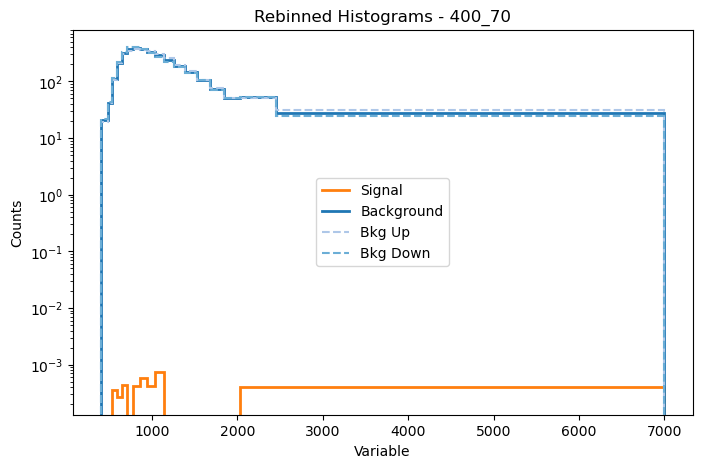

Z = 2.4750800980400287, stat_unc_b = 0.15979055906542872, stat_unc_s = 0.4807476375939014
Z = 1.9457553765129598, stat_unc_b = 0.18021943577333738, stat_unc_s = 0.8719840812486268
Plotting rebinned histograms for key: 1500_400


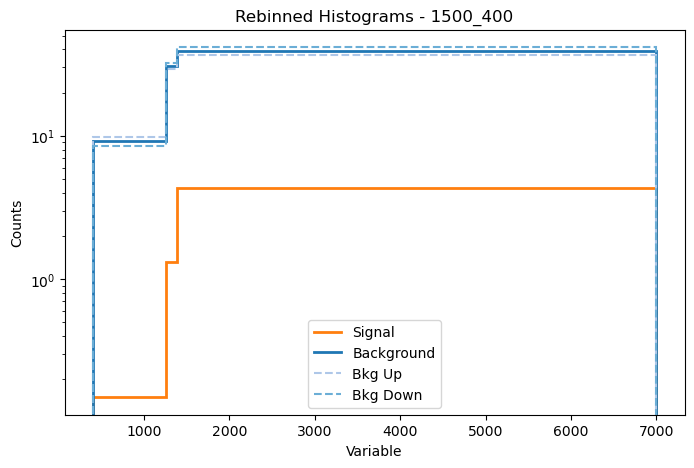

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 1.9588449953034854
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 738.5919491897027
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_

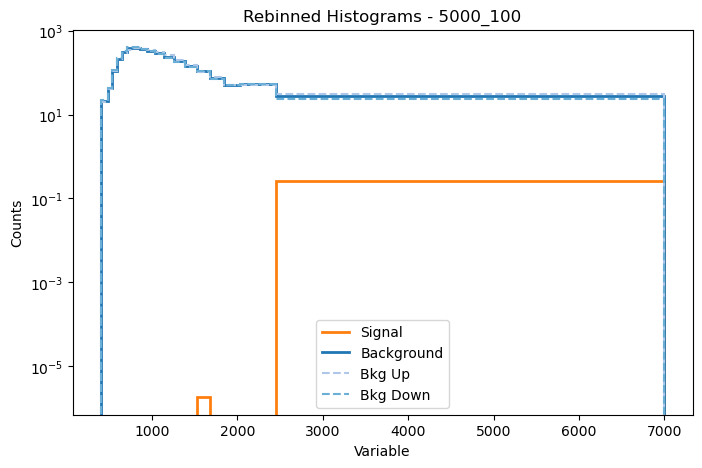

Plotting rebinned histograms for key: 2500_750


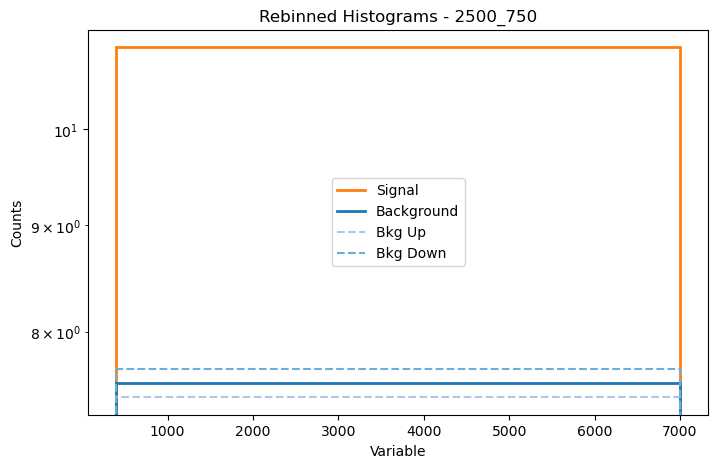

Z = 0.12491985412173112, stat_unc_b = 0.15790868853453977, stat_unc_s = 29.529201110918045
Z = 0.43035553561053735, stat_unc_b = 0.0850761961803061, stat_unc_s = 11.271082547456153
Z = 0.6848934870326383, stat_unc_b = 0.06743886347908626, stat_unc_s = 6.91777497088713
Z = 0.9029078706317555, stat_unc_b = 0.05873541497461923, stat_unc_s = 6.132588406099224
Z = 1.0424367026570933, stat_unc_b = 0.05466343437614449, stat_unc_s = 7.444557169664957
Z = 1.009370889218895, stat_unc_b = 0.055551574566653265, stat_unc_s = 17.302428061527237
Z = 0.6841357334678646, stat_unc_b = 0.06747620102359138, stat_unc_s = 19.309534915919226
Z = 0.1209799272594849, stat_unc_b = 0.16045937686841386, stat_unc_s = inf
Plotting rebinned histograms for key: 1000_750


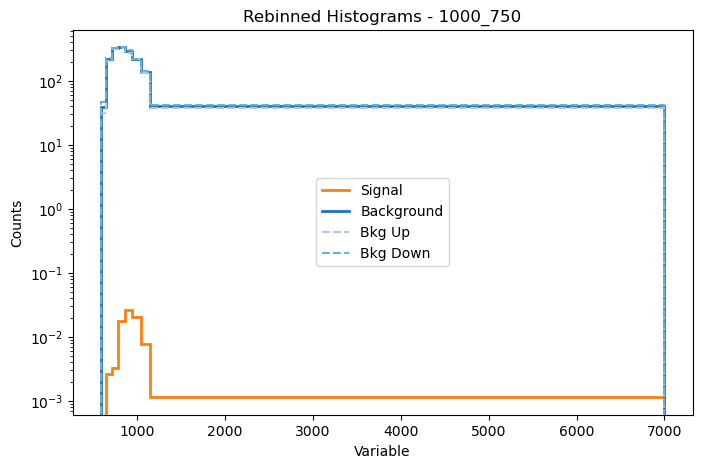

Plotting rebinned histograms for key: 5000_1000


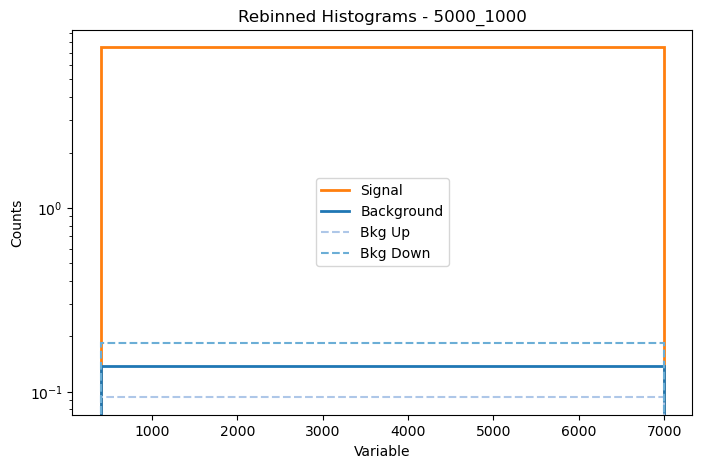

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 3.369387678946874
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 2.435622127391265
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 3.8554112698376173
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 5.854599162555519
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 11.146232093478183
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 22.895824299750565
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 23.993749313160542
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s 

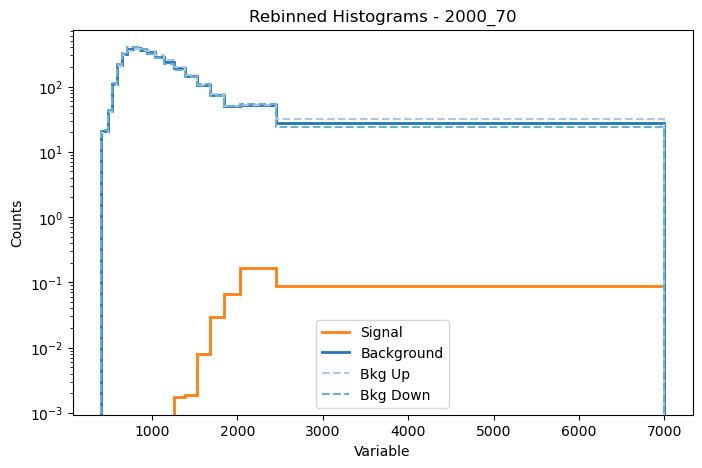

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 7.7260945877871015
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 5.672301064388029
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 5.796950643268434
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 4.3824501629734005
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 3.4262802220326383
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 3.92165444139031
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 8.206118808152903
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 10.346574206631413
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 42.6507363490735
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.0509

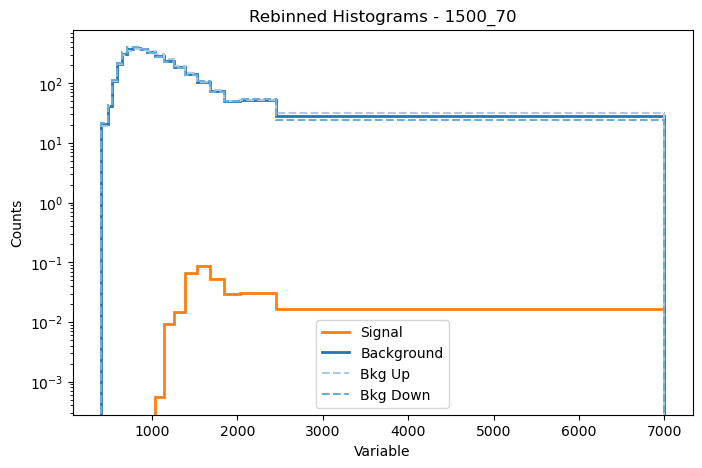

Plotting rebinned histograms for key: 5000_200


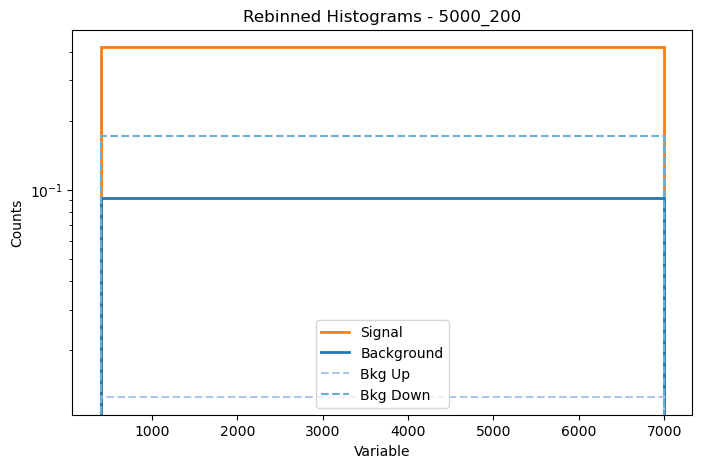

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 2.4138807644582587
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = inf
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_s = inf
Z = 0.

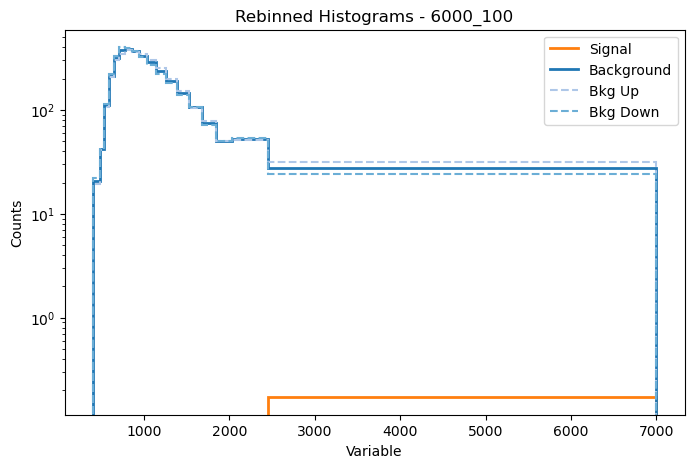

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = inf
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = inf
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = inf
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = inf
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = inf
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = inf
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = inf
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = inf
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 36.520871774018055
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = inf
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = inf
Z = 0.5779855639351648, stat_unc_b = 0.05091643791589947, stat_unc_s = inf
Z = 0.5616063694892572, stat_unc_b = 0.05165358826188366, stat_unc_s = inf
Z = 0.

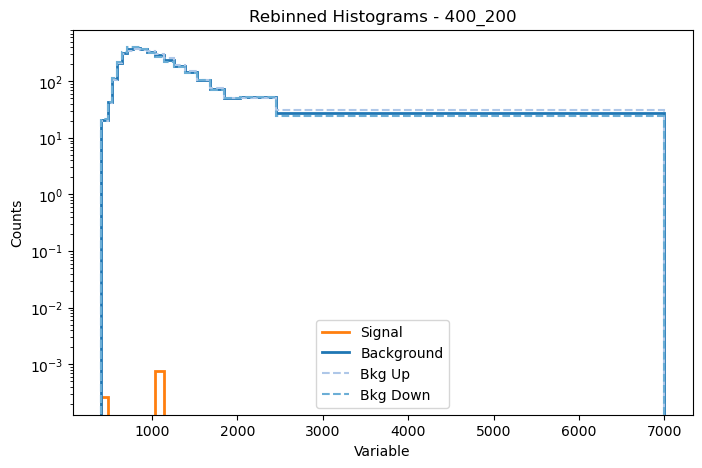

Plotting rebinned histograms for key: 3000_400


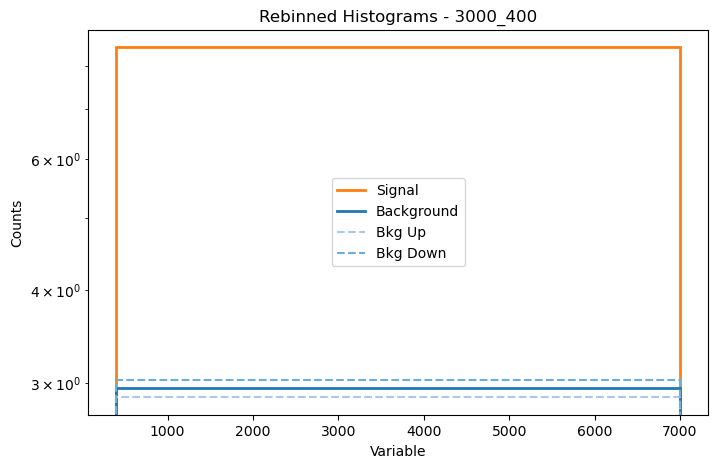

Z = 0.041550394492858606, stat_unc_b = 0.18990173518221803, stat_unc_s = 14.417274170380834
Z = 0.07878616929166132, stat_unc_b = 0.13790865290779314, stat_unc_s = 15.122397269856847
Z = 0.07538207601472441, stat_unc_b = 0.14098810130364753, stat_unc_s = 14.583629219627715
Z = 0.1116967389992027, stat_unc_b = 0.11582338726043376, stat_unc_s = 20.11552380390024
Z = 0.15895592531365965, stat_unc_b = 0.0970908152994269, stat_unc_s = 8.811010827698196
Z = 0.21749039774690926, stat_unc_b = 0.0830035113502326, stat_unc_s = 9.038747370879165
Z = 0.2836417549655282, stat_unc_b = 0.07268276273359114, stat_unc_s = 8.298545680945102
Z = 0.3583209133213474, stat_unc_b = 0.06466666001672666, stat_unc_s = 7.225718845194303
Z = 0.43265148003919873, stat_unc_b = 0.058850128016179, stat_unc_s = 3.6065214721158494
Z = 0.49942091741881794, stat_unc_b = 0.05477509566147818, stat_unc_s = 3.44362799814223
Z = 0.5508786354439174, stat_unc_b = 0.05215411063760982, stat_unc_s = 5.669891624229587
Z = 0.57798556

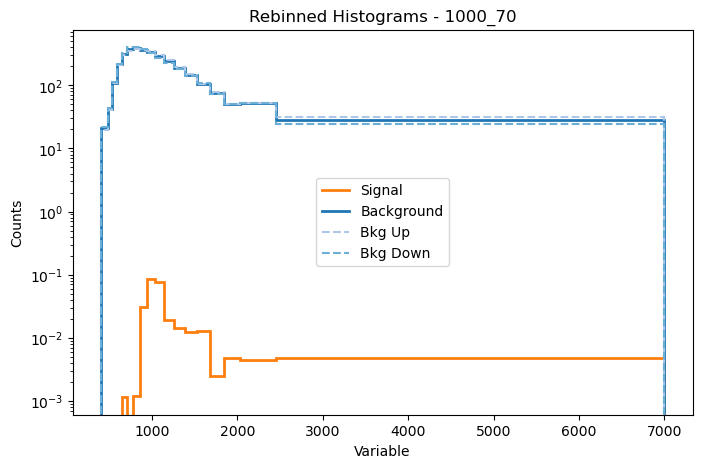

Z = 0.594070424911178, stat_unc_b = 0.09315649823039833, stat_unc_s = 48.09219952078437
Z = 1.086771268450659, stat_unc_b = 0.06887522758261679, stat_unc_s = 10.948167675007621
Z = 1.2506500329250134, stat_unc_b = 0.0642043157015983, stat_unc_s = 7.432535165764697
Z = 1.1037123414034855, stat_unc_b = 0.06834459458220629, stat_unc_s = 8.567167518412589
Z = 0.695646213971765, stat_unc_b = 0.08608706630488767, stat_unc_s = 20.107862723656762
Z = 0.2488655462453906, stat_unc_b = 0.14392947232613343, stat_unc_s = inf
Plotting rebinned histograms for key: 750_500


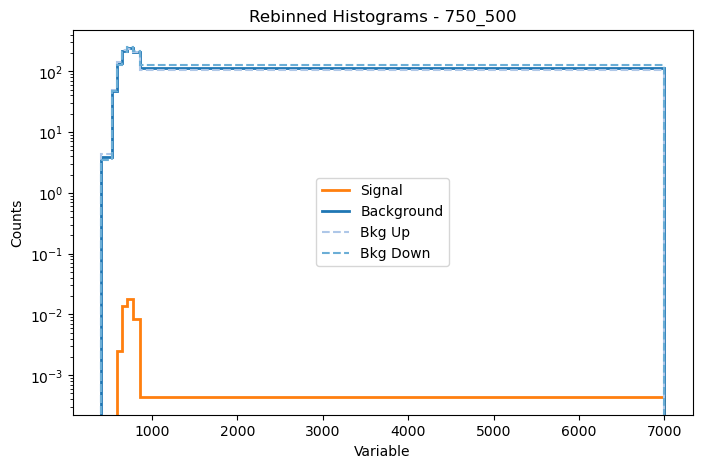

In [14]:
import matplotlib.pyplot as plt

# Dictionaries to store rebinned histograms
rebinned_sig_hists = {}
rebinned_bkg_hists = {}
rebinned_bkg_hists_up = {}
rebinned_bkg_hists_dw = {}

for key in sig_hists.keys():
    if key not in bkg_hists:
        print(f"Warning: Missing background histogram for key {key}, skipping...")
        continue
    
    # Get signal and background histograms
    sig_counts, sig_edges = sig_hists[key]
    bkg_counts, bkg_edges = bkg_hists[key]
    
    # Perform rebinning
    rebin_algo = HistogramRebinning((sig_counts, sig_edges), (bkg_counts, bkg_edges), z_s=0, z_b=5)
    new_edges, new_sig_counts, new_bkg_counts = rebin_algo.rebin_histograms()
    
    # Store rebinned histograms
    rebinned_sig_hists[key] = (new_sig_counts, new_edges)
    rebinned_bkg_hists[key] = (new_bkg_counts, new_edges)

    # Rebin the systematic variations if they exist
    new_bkg_counts_up = new_bkg_counts_dw = None  # Default to None if not found

    if key in bkg_hists_up:
        new_bkg_counts_up = rebin_algo.rebin_fixed_bins(bkg_hists_up[key][0], bkg_hists_up[key][1], new_edges)
        rebinned_bkg_hists_up[key] = (new_bkg_counts_up, new_edges)

    if key in bkg_hists_dw:
        new_bkg_counts_dw = rebin_algo.rebin_fixed_bins(bkg_hists_dw[key][0], bkg_hists_dw[key][1], new_edges)
        rebinned_bkg_hists_dw[key] = (new_bkg_counts_dw, new_edges)

    # Plot the rebinned histograms
    print(f"Plotting rebinned histograms for key: {key}")
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot signal and background with updated colors
    ax.stairs(new_sig_counts, new_edges, linestyle='-', linewidth=2, label='Signal', color='#ff7f0e')  # Orange
    ax.stairs(new_bkg_counts, new_edges, linestyle='-', linewidth=2, label='Background', color='#1f77b4')  # Dark Blue

    # Plot background variations
    if new_bkg_counts_up is not None:
        ax.stairs(new_bkg_counts_up, new_edges, linestyle='--', linewidth=1.5, label='Bkg Up', color='#aec7e8')  # Light Blue

    if new_bkg_counts_dw is not None:
        ax.stairs(new_bkg_counts_dw, new_edges, linestyle='--', linewidth=1.5, label='Bkg Down', color='#6baed6')  # Sky Blue

    ax.set_xlabel('Variable')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.legend()
    ax.set_title(f'Rebinned Histograms - {key}')
    
    plt.show()



In [ ]:
# Initialize and run the algorithm
rebin_algo = HistogramRebinning(sig_hists['2500_250'], bkg_hists['2500_250'], z_s=2, z_b=1)
new_edges, new_sig_counts, new_bkg_counts = rebin_algo.rebin_histograms()

print("New bin edges:", new_edges)
print("Rebinned signal counts:", new_sig_counts)
print("Rebinned background counts:", new_bkg_counts)

# Plot the rebinned histograms
rebin_algo.plot_histograms(new_edges, new_sig_counts, new_bkg_counts)